# Master Thesis (Electricity Trading on Intraday Market in Japan)

## 節立てのしかた
### To doメモ：日次データから15分足への変換、その他データのYahoo Finance からのダウンロード
### 複数行コメントアウトは「Ctrl + /」
### 小技集(時系列データ用)
https://naotaka1128.hatenadiary.jp/entry/pandas-start-guide#%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%A7%E3%82%88%E3%81%8F%E4%BD%BF%E3%81%86%E5%87%A6%E7%90%86

# Problem

- An increase in the proportion for the renewable energy power plant in German electricity industry.<p>
- Predicting the amount of electricity supply is becoming more difficult<p>
- The trading volume on the intraday market in Germany is also increasing. <p>
    --> The difference of the planned and the actual electricity supply is expanded. <p>
- The trading price of intraday market tends to be volatile.<p> 
- The electricity suppliers, including producers and retailers, suffered from an unevitable risk due to the uncertainty after submitting day-ahead plan.<p>

# Purpose of this analysis

- Interpreting the dataset of electricity trading.<p>
- Seeking useful features for the prediction. <p>
- Seeking more efficient prediction model for intraday Half Hourly(QH) trading price.<p>
    Intradayのclose priceを予測する！！<p>
    --> Comparision of the performance of some prediction models such as Linear, Non-linear.<p>
- Seeking better trading strategy to maximise return and minimise the risk<p>
    --> Measuring the return with Sharp ratio and the risk with Value at risk

## To do (優先順)

※4.6  需要電力計　＋　電源別発電量(東北電力サイトより)_2020_12月未入手 <P>
    Date leaking整理 <p>
    lag features (Data leakingを調整のみ、seasonality確認後に再度調整) <p>
    modelにprophetとARIMAを追加 <p>
    その後 EDA <p>

# Read & interpret dataset

Loading some datasets <p>
Confirming and interpreting it <p>
Preprocessing missing values and outliers on the datasets

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pathlib
import pandas_datareader.data as web #データのダウンロードライブラリ
import glob
import math

# Show all the rows and columns up to 200
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

ImportError: cannot import name 'urlencode' from 'pandas.io.common' (/usr/local/lib/python3.7/site-packages/pandas/io/common.py)

## JEPX_Spot_datasets
http://www.jepx.org/market/index.html

<やること><P>
    季節性、定常性の確認 (以下git-hub講義資料参照) <p>
    https://github.com/mloning/intro-to-ml-with-time-series-DSSGx-2020/blob/master/notebooks/02_exploratory_data_analysis.ipynb <p>
    https://github.com/juanitorduz/btsa/blob/master/python/fundamentals/notebooks/eda_part_2_correlations.ipynb

In [20]:
# read the dataset (Here, these are re-organised after getting the latest dataset)

#Spot_dataset
df_spot_2016 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/spot_2016.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2017 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/spot_2017.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2018 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/spot_2018.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2019 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/spot_2019.csv', sep=',', header=0, encoding='shift_jis')
df_spot_2020 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/spot_2020.csv', sep=',', header=0, encoding='shift_jis')

In [21]:
df_spot_2020.head()

,年月日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),...,回避可能原価全国値(円/kWh),回避可能原価北海道(円/kWh),回避可能原価東北(円/kWh),回避可能原価東京(円/kWh),回避可能原価中部(円/kWh),回避可能原価北陸(円/kWh),回避可能原価関西(円/kWh),回避可能原価中国(円/kWh),回避可能原価四国(円/kWh),回避可能原価九州(円/kWh)
0,2020/04/01,1,16592450,18033600,15772950,6.43,6.84,6.76,6.76,4.00,...,6.43,6.84,6.77,6.76,4.03,4.00,4.00,4.00,4.00,4.00
1,2020/04/01,2,16986950,18180600,15766550,5.77,6.62,6.62,6.62,3.73,...,5.77,6.63,6.63,6.62,3.75,3.73,3.73,3.73,3.73,3.73
2,2020/04/01,3,17263950,18234450,15990350,5.18,6.61,6.61,6.61,4.09,...,5.19,6.64,6.61,6.61,4.10,4.09,4.09,4.09,4.09,4.09
3,2020/04/01,4,17583250,18565050,16078100,4.87,6.51,6.51,6.51,4.04,...,4.87,6.52,6.51,6.51,4.05,4.04,4.04,4.04,4.04,4.04
4,2020/04/01,5,17943550,18738950,16338200,4.87,6.51,6.51,6.51,4.09,...,4.87,6.52,6.51,6.51,4.10,4.09,4.09,4.09,4.09,4.09


In [22]:
# marge all the spot datasets
df_spot = pd.concat([df_spot_2016, df_spot_2017])
df_spot = pd.concat([df_spot, df_spot_2018])
df_spot = pd.concat([df_spot, df_spot_2019])
df_spot = pd.concat([df_spot, df_spot_2020])

In [23]:
# Pick up some columns
df_spot = df_spot.drop(['エリアプライス北海道(円/kWh)', 'エリアプライス中部(円/kWh)', 'エリアプライス北陸(円/kWh)',
       'エリアプライス関西(円/kWh)', 'エリアプライス中国(円/kWh)', 'エリアプライス四国(円/kWh)',
       'エリアプライス九州(円/kWh)', 'Unnamed: 15', 'スポット・時間前平均価格(円/kWh)',
       'α上限値×スポット・時間前平均価格(円/kWh)', 'α下限値×スポット・時間前平均価格(円/kWh)',
       'α速報値×スポット・時間前平均価格(円/kWh)', 'α確報値×スポット・時間前平均価格(円/kWh)', 'Unnamed: 21',
       '回避可能原価全国値(円/kWh)', '回避可能原価北海道(円/kWh)', '回避可能原価東北(円/kWh)',
       '回避可能原価東京(円/kWh)', '回避可能原価中部(円/kWh)', '回避可能原価北陸(円/kWh)',
       '回避可能原価関西(円/kWh)', '回避可能原価中国(円/kWh)', '回避可能原価四国(円/kWh)',
       '回避可能原価九州(円/kWh)'], axis=1)

In [24]:
# Rename them
df_spot = df_spot.rename(columns={'年月日': 'Date', '時刻コード': 'HH', '売り入札量(kWh)': 'Sell_volume(kWh)',
                                  '買い入札量(kWh)': 'Buy_volume(kWh)', '約定総量(kWh)': 'Total_volume(kWh)', 'システムプライス(円/kWh)': 'System_price(Yen/kWh)', 
                                  'エリアプライス東北(円/kWh)': 'Price_Tohoku(Yen/kWh)','エリアプライス東京(円/kWh)': 'Price_Tokyo(Yen/kWh)'})

In [25]:
# Apply to_datetime
df_spot["Date"] = pd.to_datetime(df_spot["Date"]).dt.date

In [26]:
df_spot.head()

,Date,HH,Sell_volume(kWh),Buy_volume(kWh),Total_volume(kWh),System_price(Yen/kWh),Price_Tohoku(Yen/kWh),Price_Tokyo(Yen/kWh)
0,2016-04-01,1,5077000,2120500,675500,6.61,6.69,6.69
1,2016-04-01,2,5621500,2239000,755500,6.34,6.34,6.34
2,2016-04-01,3,5710500,2219000,713500,6.34,6.34,6.34
3,2016-04-01,4,5536000,2202500,717500,6.25,6.03,6.03
4,2016-04-01,5,5461000,2192000,870500,6.57,6.57,6.57


In [27]:
spotprice = df_spot
spotprice = spotprice.set_index(["Date", "HH"])

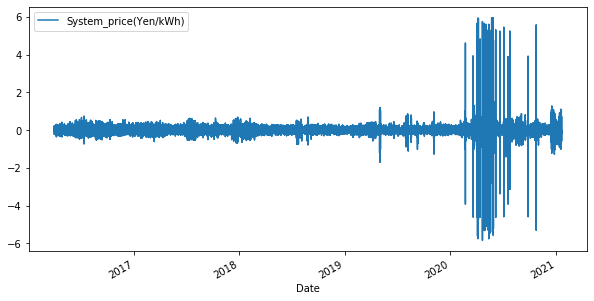

In [28]:
# Plot logarithmic return (対数リターン)下落率と上昇率を同等に扱う 
p = spotprice[["System_price(Yen/kWh)"]]
rets_spot = np.log(p / p.shift(1))
rets_spot.reset_index(inplace = True)
rets_spot.drop("HH", axis=1, inplace=True)
rets_spot = rets_spot.set_index("Date")
rets_spot.dropna(inplace=True)

rets_spot.plot(subplots=True, figsize=(10, 5));

y軸の名前・単位を追加する！！

In [29]:
rets_spot.describe()

,System_price(Yen/kWh)
count,84335.000000
mean,0.000025
std,0.177481
min,-5.840642
25%,-0.026941
50%,0.000000
75%,0.021851
max,5.953243


- Multiindexを用いた行列調整　https://note.nkmk.me/python-pandas-multiindex-set-reset-sort-swap/

- (参考)　- stack()を用いた列→行への変換方法
https://deepage.net/features/pandas-stack-unstack.html

- pivot_tableの使い方 (stack, unstackも含む)
https://note.nkmk.me/python-pandas-stack-unstack-pivot/

## JEPX_Intra_datasets
http://www.jepx.org/market/index.html

In [30]:
# read the dataset (Here, these are re-organised after getting the latest dataset)

#Intra_dataset
df_intra_2016 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/im_trade_summary_2016.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2017 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/im_trade_summary_2017.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2018 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/im_trade_summary_2018.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2019 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/im_trade_summary_2019.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2020 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/im_trade_summary_2020.csv', sep=',', header=0, encoding='shift_jis')

### Price volatility

In [31]:
# marge all the intra datasets
df_intra = pd.concat([df_intra_2016, df_intra_2017])
df_intra = pd.concat([df_intra, df_intra_2018])
df_intra = pd.concat([df_intra, df_intra_2019])
df_intra = pd.concat([df_intra, df_intra_2020])

In [32]:
df_intra = df_intra.rename(columns={'年月日': 'Date', 
                                    '時刻コード': 'HH',
                                    '始値（円/kWh）': 'Open',
                                    '高値（円/kWh）': 'High',
                                    '安値（円/kWh）': 'Low',
                                    '終値（円/kWh）': 'Close',
                                    '平均（円/kWh）': 'Average',
                                    '約定量合計（MWh/h）': 'Volume(MWh/h)',
                                    '約定件数': 'Volume(Tick count)'})

In [33]:
# Apply to_datetime
df_intra["Date"] = pd.to_datetime(df_intra["Date"]).dt.date

In [34]:
print(df_intra["HH"].value_counts())

1     1756
32    1756
24    1756
2     1756
26    1756
27    1756
28    1756
29    1756
30    1756
31    1756
33    1756
22    1756
34    1756
35    1756
36    1756
37    1756
38    1756
39    1756
40    1756
41    1756
23    1756
25    1756
21    1756
11    1756
3     1756
4     1756
5     1756
6     1756
7     1756
20    1756
9     1756
10    1756
8     1756
12    1756
13    1756
14    1756
15    1756
16    1756
17    1756
18    1756
19    1756
42    1755
43    1755
44    1755
45    1755
46    1755
47    1755
48    1755
Name: HH, dtype: int64


In [35]:
df_intra.head()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count)
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1
1,2016-04-01,2,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2016-04-01,3,7.21,7.21,7.21,7.21,7.21,0.8,1
3,2016-04-01,4,7.06,7.06,7.06,7.06,7.06,0.8,1
4,2016-04-01,5,7.21,7.21,7.21,7.21,7.21,0.8,1


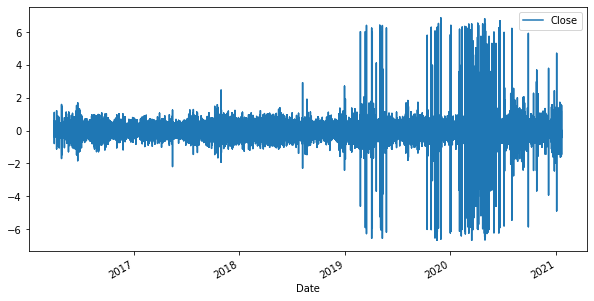

In [36]:
# Plot logarithmic return (対数リターン)下落率と上昇率を同等に扱う 
intraprice = df_intra
intraprice = intraprice.set_index(["Date", "HH"])
intraprice = intraprice[["Close"]]
rets = np.log(intraprice / intraprice.shift(1))
rets.reset_index(inplace = True)
rets.drop("HH", axis=1, inplace=True)
rets = rets.set_index("Date")
rets.dropna(inplace=True)
rets.plot(subplots=True, figsize=(10, 5));

可能であれば、2019年からなぜボラが上がったのか検証
→再生可能エネルギの総需要に対する比率の推移をみていく

In [37]:
intraprice.describe()

,Close
count,84209.000000
mean,9.553096
std,11.992722
min,0.010000
25%,6.140000
50%,7.990000
75%,10.000000
max,260.310000


### Plot candle chart for intraday prices (一旦スキップ)
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
                open=df_intra['Open'], high=df_intra['High'],
                low=df_intra['Low'], close=df_intra['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [38]:
# Candle stick (一旦スキップ)
df_intra_quotes = df_intra[]
tohoku_quotes = df_intra[["Open", "High", "Low", "Close"]]
tohoku_quotes.reset_index(inplace = True)
tohoku_quotes.drop(["Date","HH"], axis=1, inplace=True)
#tohoku_quotes = tohoku_quotes.set_index()
tohoku_quotes.dropna(inplace=True)
tohoku_quotes.tail()

SyntaxError: invalid syntax (<ipython-input-38-b963cb2407a2>, line 2)

### Trading vollume from 2014 to 2019

In [39]:
print(df_intra.isnull().sum())

Date                   0
HH                     0
Open                  72
High                  72
Low                   72
Close                 72
Average               72
Volume(MWh/h)         72
Volume(Tick count)     0
dtype: int64


In [40]:
df_intra["Volume(MWh/h)"].fillna(0, inplace=True)

In [41]:
df_intra.head()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count)
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1
1,2016-04-01,2,NaN,NaN,NaN,NaN,NaN,0.0,0
2,2016-04-01,3,7.21,7.21,7.21,7.21,7.21,0.8,1
3,2016-04-01,4,7.06,7.06,7.06,7.06,7.06,0.8,1
4,2016-04-01,5,7.21,7.21,7.21,7.21,7.21,0.8,1


Mean of the volume on each item

In [42]:
df_intra_HHvol_mean =  df_intra.groupby("HH").agg({"Volume(MWh/h)": 'mean', "Volume(Tick count)": 'mean'}).reset_index()
df_intra_HHvol_mean = df_intra_HHvol_mean.set_index("HH")
df_intra_HHvol_mean.head()

,Volume(MWh/h),Volume(Tick count)
HH,,
1,155.934909,46.953303
2,158.440547,46.451595
3,155.112813,45.703303
4,158.398519,45.483485
5,166.506777,46.639522


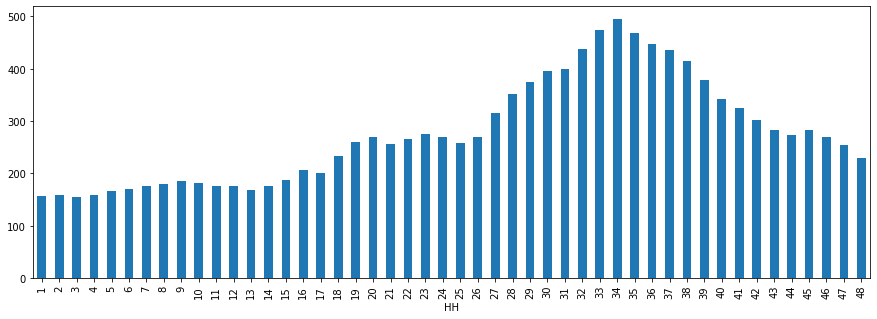

In [43]:
df_intra_HHvol_mean["Volume(MWh/h)"].plot.bar(figsize=(15, 5));

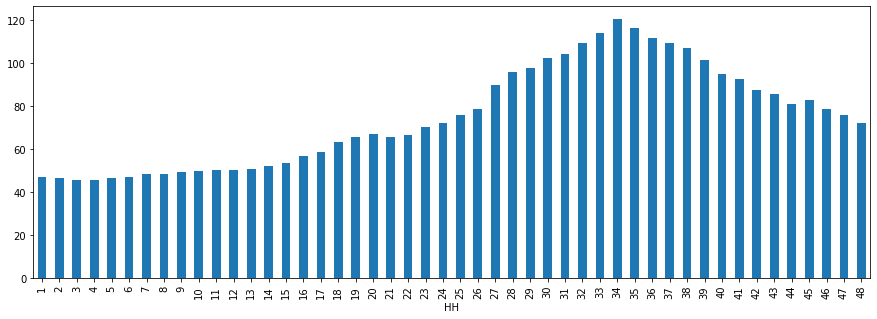

In [44]:
df_intra_HHvol_mean["Volume(Tick count)"].plot.bar(figsize=(15, 5));

Median of the volume on each item

In [45]:
df_intra_HHvol_median =  df_intra.groupby("HH").agg({"Volume(MWh/h)": 'median', "Volume(Tick count)": 'median'}).reset_index()
df_intra_HHvol_median = df_intra_HHvol_median.set_index("HH")
df_intra_HHvol_median.head()

,Volume(MWh/h),Volume(Tick count)
HH,,
1,89.40,42.0
2,86.50,41.0
3,89.00,41.0
4,88.95,40.0
5,95.75,41.0


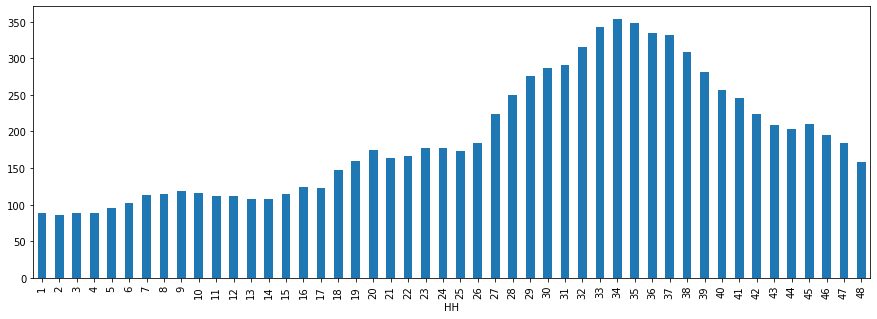

In [46]:
df_intra_HHvol_median["Volume(MWh/h)"].plot.bar(figsize=(15, 5));

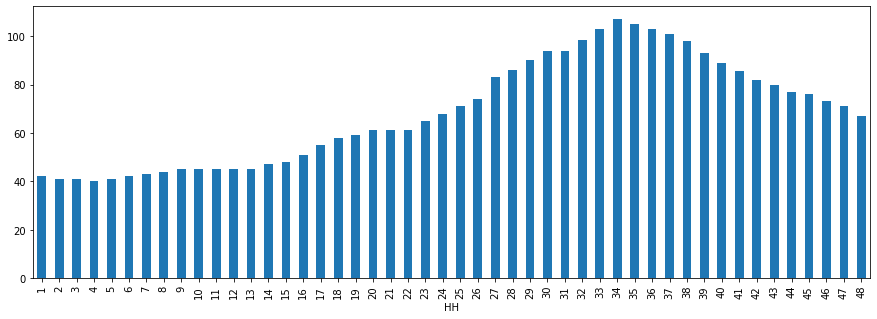

In [47]:
df_intra_HHvol_median["Volume(Tick count)"].plot.bar(figsize=(15, 5));

どのスロットのアイテムも無視できない...

In [48]:
df_intra_dayvolume = df_intra.groupby("Date").agg({"Volume(MWh/h)": 'sum', "Volume(Tick count)": 'sum'}).reset_index()
df_intra_dayvolume = df_intra_dayvolume.iloc[-200:]
df_intra_dayvolume = df_intra_dayvolume.set_index("Date")
df_intra_dayvolume.tail()

,Volume(MWh/h),Volume(Tick count)
Date,,
2021-01-16,18768.8,4727
2021-01-17,23346.0,4340
2021-01-18,19692.8,4700
2021-01-19,17527.7,3977
2021-01-20,28011.7,5140


In [49]:
import matplotlib.dates as mdates

# 描画
fig, ax = plt.subplots(figsize=(15, 5))
df_intra_dayvolume['Volume(MWh/h)'].plot.bar(  # indexがx軸に。各columnが各線に。
    ax=ax,
    rot=True,  # 指定しない場合、ラベルが横倒しになる
    legend=False,  # 凡例OFF
)

# 軸目盛の設定
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=, tz=None))

plt.show()

#df_intra_dayvolume["Volume(MWh/h)"].plot.bar(interval=7, figsize=(15, 5));

SyntaxError: invalid syntax (<ipython-input-49-fa8dd39e5b5c>, line 12)

In [ ]:
df_intra_dayvolume["Volume(Tick count)"].plot.bar(figsize=(15, 5));

### そのた個別のEDA (特にターゲットデータ)

ここではもっとデータを見てもいい。例えば、<p>
- 価格データの季節性、定常性、など <p>
- 対数化もしくは正則化 (参照：https://uribo.github.io/practical-ds/02/numeric.html) 
- ターゲットの分布 
- 外れ値　など

In [ ]:
print(df_train['item_cnt_day'].value_counts())

In [ ]:
plt.hist(df_train['item_cnt_day'], bins=10, range=(0, 10), rwidth=1.0)

## Weather data (Tohoku area)
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

データを価格データと結合後、欠損値を条件付きで埋めていく方法

Dateを日付と時間に分割

必要な列を抽出

HH_tableを適用（当データにHH_tableを結合）

データ統合後、欠損値を各列ごとに埋めていく

In [ ]:
#Read all the weather data in Tohoku area

df_weather_Aomori = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Aomori.csv', sep=',', header=0, encoding='cp932')
df_weather_Akita = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Akita.csv', sep=',', header=0, encoding='cp932')
df_weather_Morioka = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Morioka.csv', sep=',', header=0, encoding='cp932')
df_weather_Yamagata = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Yamagata.csv', sep=',', header=0, encoding='cp932')
df_weather_Sendai = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Sendai.csv', sep=',', header=0, encoding='cp932')
df_weather_Fukushima = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Fukushima.csv', sep=',', header=0, encoding='cp932')
df_weather_Niigata = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Weather/Weather_Niigata.csv', sep=',', header=0, encoding='cp932')

In [ ]:
print(df_weather_Aomori.shape)
print(df_weather_Akita.shape)
print(df_weather_Morioka.shape)
print(df_weather_Yamagata.shape)
print(df_weather_Sendai.shape)
print(df_weather_Fukushima.shape)
print(df_weather_Niigata.shape)

In [ ]:
# marge all the spot datasets
df_weather_all = pd.merge(df_weather_Aomori, df_weather_Akita, how='left', on=['Date'])
df_weather_all = pd.merge(df_weather_all, df_weather_Morioka, how='left', on=['Date'])
df_weather_all = pd.merge(df_weather_all, df_weather_Yamagata, how='left', on=['Date'])
df_weather_all = pd.merge(df_weather_all, df_weather_Sendai, how='left', on=['Date'])
df_weather_all = pd.merge(df_weather_all, df_weather_Fukushima, how='left', on=['Date'])
df_weather_all = pd.merge(df_weather_all, df_weather_Niigata, how='left', on=['Date'])
print(df_weather_all.shape)

In [ ]:
#Drop the columns that are not necessary
a = [item for item in df_weather_all.columns if item.find('Qual') != -1 or item.find('Num') != -1or item.find('None') != -1]
df_weather_all = df_weather_all.drop(columns=a)

In [50]:
# Replace/adjust the name of direction
df_weather_all = df_weather_all.replace({'北西)': '北西', '南東)': '南東', '東南東)': '東南東', '南)': '南'})

# Categolize direction
df_weather_all = df_weather_all.replace({'静穏': '0', '北': '1', '北北東': '2', '北東': '3', 
                                        '東北東': '4', '東': '5', '東南東': '6', '南東': '7', '南南東': '8', 
                                        '南': '9', '南南西': '10', '南西': '11', '西南西': '12', 
                                        '西': '13', '西北西': '14', '北西': '15', '北北西': '16'})

In [51]:
df_weather_all["Time"] = pd.to_datetime(df_weather_all["Date"]).dt.time
df_weather_all["Date"] = pd.to_datetime(df_weather_all["Date"]).dt.date

In [52]:
cols = [item for item in df_weather_all.columns if item.find('WindDirection') != -1]
df_weather_all[cols] = df_weather_all[cols].apply(pd.to_numeric)

In [53]:
df_weather_all.head()

,Date,Temp_Ao,SunLight(Time)_Ao,WindSpeed(m/s)_Ao,WindDirection_Ao,SunLight(MJ/㎡)_Ao,Temp_Aki,SunLight(Time)_Aki,WindSpeed(m/s)_Aki,WindDirection_Aki,...,SunLight(Time)_Fu,WindSpeed(m/s)_Fu,WindDirection_Fu,SunLight(MJ/㎡)_Fu,Temp_Ni,SunLight(Time)_Ni,WindSpeed(m/s)_Ni,WindDirection_Ni,SunLight(MJ/㎡)_Ni,Time
0,2016-04-01,2.1,0.0,2.4,10.0,0.0,3.5,0.0,1.9,6.0,...,0.0,0.9,5.0,0.0,8.2,0.0,0.5,6.0,0.0,00:00:00
1,2016-04-01,1.5,0.0,1.5,11.0,0.0,3.4,0.0,2.5,5.0,...,0.0,0.4,9.0,0.0,7.4,0.0,0.7,4.0,0.0,00:00:00
2,2016-04-01,1.2,0.0,0.3,6.0,0.0,3.2,0.0,2.4,6.0,...,0.0,0.7,8.0,0.0,7.0,0.0,1.7,7.0,0.0,00:00:00
3,2016-04-01,0.4,0.0,1.7,10.0,0.0,2.5,0.0,1.9,5.0,...,0.0,0.3,9.0,0.0,6.3,0.0,1.2,4.0,0.0,00:00:00
4,2016-04-01,0.1,0.0,1.5,11.0,0.0,2.1,0.0,1.5,6.0,...,0.0,0.8,4.0,0.0,6.6,0.0,1.4,5.0,0.0,00:00:00


準備OK　--> Mergeしてから30分時点の欠損値は直前の時間の情報を参照させる (もしくは直前の時間を参照してすべて２で割る)

In [54]:
df_Temp = df_weather_all.iloc[:, df_weather_all.columns.str.contains("Temp")]
df_SunLight_Time = df_weather_all.iloc[:, df_weather_all.columns.str.contains("SunLight" and "Time")].drop("Time", axis=1)
df_SunLight_Volume = df_weather_all.iloc[:, df_weather_all.columns.str.contains("SunLight" and "MJ/㎡")]
df_WindSpeed = df_weather_all.iloc[:, df_weather_all.columns.str.contains("WindSpeed")]
df_WindDirection = df_weather_all.iloc[:, df_weather_all.columns.str.contains("WindDirection")]

In [55]:
df_SunLight_Time.shape

(41664, 7)

In [56]:
print(df_SunLight_Time.isnull().sum())

SunLight(Time)_Ao     6
SunLight(Time)_Aki    8
SunLight(Time)_Mo     3
SunLight(Time)_Ya     3
SunLight(Time)_Se     2
SunLight(Time)_Fu     2
SunLight(Time)_Ni     1
dtype: int64


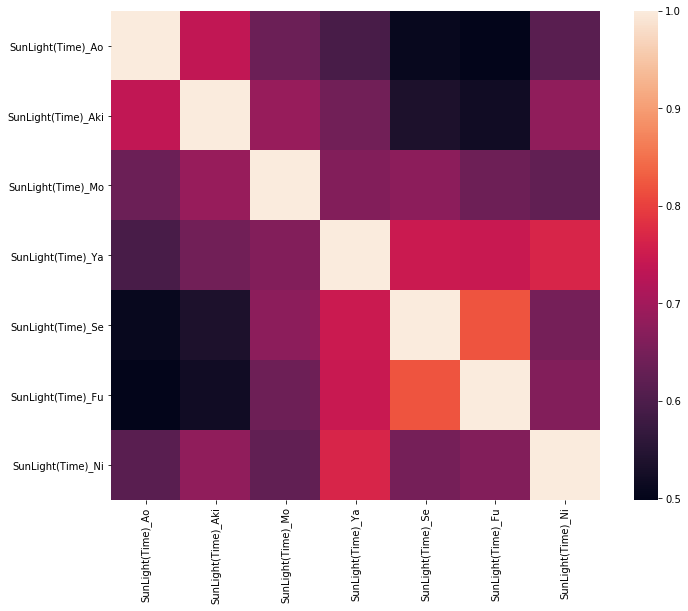

In [57]:
# correlation matrix
corrmat = df_SunLight_Time.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True);

df_Temp: 相関高い -->　平均
df_SunLight_Time: 相関はバラけている
df_SunLight_Volume: 青森 と 仙台/福島が相関0.5程度と低め
df_WindSpeed: 相関低め
df_WindDirection 相関低め

## Actual_generation(Tohoku_area) ※2020年11月まで入手済！！
http://occtonet.occto.or.jp/public/dfw/RP11/OCCTO/SD/LOGIN_login#

Timegrouperで5分値を３０分値へ
https://qiita.com/takechanman1228/items/00daec6a62f831f24e6d

In [58]:
#Actual generation_dataset from 2016-08-01
df_actual_generation_1 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Actual_generation_5min/Actual_generation1.csv', sep=',', header=0, encoding='shift_jis')

#Actual generation_dataset from 2020-04-14
df_actual_generation_2 = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/Actual_generation_5min/Actual_generation2.csv', sep=',', header=0, encoding='shift_jis')

In [59]:
df_actual_generation_Tohoku = pd.concat([df_actual_generation_1, df_actual_generation_2])
df_actual_generation_Tohoku = df_actual_generation_Tohoku.rename(columns={'DATE': 'Date', 'TIME': 'Time',
    '太陽光発電実績(5分間隔値)(万kW)': 'gen_Solar(mkW)', '当日実績(5分間隔値)(万kW)': 'gen_all(mkW)', '風力発電実績(5分間隔値)(万kW)': 'gen_Wind(mkW)'
})

In [60]:
df_actual_generation_Tohoku["gen_Solar(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_all(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_Wind(mkW)"].fillna(0, inplace=True)

In [61]:
df_actual_generation_Tohoku["DateTime"] = pd.to_datetime(df_actual_generation_Tohoku["Date"] + " " + df_actual_generation_Tohoku["Time"])

In [62]:
df_actual_generation_Tohoku = df_actual_generation_Tohoku.groupby(pd.Grouper(key="DateTime", freq='30min')).sum()

In [63]:
df_actual_generation_Tohoku.reset_index(inplace = True)

In [64]:
df_actual_generation_Tohoku["Time"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.time
df_actual_generation_Tohoku["Date"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.date
df_actual_generation_Tohoku = df_actual_generation_Tohoku.drop("DateTime", axis=1)

In [65]:
df_actual_generation_Tohoku.head()

,gen_all(mkW),gen_Solar(mkW),gen_Wind(mkW),Time,Date
0,4582.0,0.0,0.0,00:00:00,2016-08-01
1,4444.0,0.0,0.0,00:30:00,2016-08-01
2,4410.0,0.0,0.0,01:00:00,2016-08-01
3,4368.0,0.0,0.0,01:30:00,2016-08-01
4,4379.0,0.0,0.0,02:00:00,2016-08-01


In [66]:
print(df_actual_generation_Tohoku.isnull().sum())

gen_all(mkW)      0
gen_Solar(mkW)    0
gen_Wind(mkW)     0
Time              0
Date              0
dtype: int64


準備オッケー

## 時間足需要電力計_All (需要実績, 日別, すべての期間, すべてのエリア)
http://occtonet.occto.or.jp/public/dfw/RP11/OCCTO/SD/LOGIN_login#

時間帯の表記をHH_tableにあわせる

In [67]:
# Hourly demand All_広域
df_HourlyDemand_All = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/需要実績(日別)_ALL.csv', sep=',', header=0, encoding='shift_jis')

In [68]:
# Rename the columns
df_HourlyDemand_All = df_HourlyDemand_All.rename(columns={'年月日': 'Date', '時間帯': 'Period', 
                                                                  '北海道': 'Hokkaido', '東北': 'Tohoku', '東京': 'Tokyo', '中部': 'Chubu', 
                                                                  '北陸': 'Hokuriku', '関西': 'Kansai', '中国': 'Chugoku',
                                                                  '四国': 'Shikoku', '九州': 'Kyushu', '沖縄': 'Okinawa',
                                                                  '１０エリア計': 'Total'
})

In [69]:
# Convert text on the Period column to NaN
df_HourlyDemand_All['Period'] = df_HourlyDemand_All['Period'].replace({'日電力量(MWh)': np.nan, '日最大電力(MW)': np.nan})

In [70]:
# Remove the rows that include NaN
df_HourlyDemand_All = df_HourlyDemand_All[~df_HourlyDemand_All.Period.str.contains("NaN", na=True)]

In [71]:
# Make the column for "DateTime"
df_HourlyDemand_All["DateTime"] = pd.to_datetime(df_HourlyDemand_All["Date"] + " " + df_HourlyDemand_All["Period"].str[:5])

In [72]:
df_HourlyDemand_All["Time"] = pd.to_datetime(df_HourlyDemand_All["DateTime"]).dt.time
df_HourlyDemand_All["Date"] = pd.to_datetime(df_HourlyDemand_All["DateTime"]).dt.date

In [73]:
df_HourlyDemand_All = df_HourlyDemand_All.drop(["Period", "DateTime"], axis=1)

In [74]:
print(df_HourlyDemand_All["Time"].value_counts())

04:00:00    1755
20:00:00    1755
05:00:00    1755
01:00:00    1755
09:00:00    1755
00:00:00    1755
03:00:00    1755
18:00:00    1755
08:00:00    1755
06:00:00    1755
02:00:00    1755
17:00:00    1755
16:00:00    1755
21:00:00    1755
14:00:00    1755
10:00:00    1755
13:00:00    1755
12:00:00    1755
15:00:00    1755
19:00:00    1755
07:00:00    1755
22:00:00    1755
23:00:00    1755
11:00:00    1755
Name: Time, dtype: int64


In [75]:
df_HourlyDemand_All.tail()

,Date,Hokkaido,Tohoku,Tokyo,Chubu,Hokuriku,Kansai,Chugoku,Shikoku,Kyushu,Okinawa,Total,Time
45623,2021-01-19,4875,13849,47574,21446,4884.2,22489.041,9648.096,4271,13052.0,950.1,143038.437,19:00:00
45624,2021-01-19,4791,13316,45771,20683,4716.2,21577.170,9219.801,4128,12639.0,933.2,137774.371,20:00:00
45625,2021-01-19,4748,12682,43551,19875,4566.7,20555.254,8857.116,3872,12067.0,886.1,131660.170,21:00:00
45626,2021-01-19,4567,12093,40735,18674,4401.8,19304.379,8312.672,3551,11485.0,833.2,123957.051,22:00:00
45627,2021-01-19,4684,12098,37972,18100,4438.4,18225.116,8055.683,3482,10960.0,786.8,118801.999,23:00:00


準備OK

## 需要電力計　＋　電源別発電量(東北電力サイトより)_2020_12月未入手
https://setsuden.nw.tohoku-epco.co.jp/download.html (※2)

In [76]:
#Total demand and generation by different type of plants_広域
df_DemandPlant_tohoku = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/actual_generation_and_demand_Tohoku' + "/Demand_plant_tohoku.csv", sep=',', header=0, encoding='shift_jis')

In [77]:
# Rename the columns
df_DemandPlant_tohoku = df_DemandPlant_tohoku.rename(columns={'DATE_TIME': 'DateTime', 'エリア需要〔MWh〕': 'AreaDemand(MWh)', 
                                                                  '水力〔MWh〕': 'Water(MWh)', '火力〔MWh〕': 'Thermal(MWh)', '原子力〔MWh〕': 'Nuclear(MWh)', 
                                                              '太陽光実績〔MWh〕': 'Actual_Solar(MWh)', '太陽光抑制量〔MWh〕': 'Curtailment_Solar(MWh)', 
                                                              '風力実績〔MWh〕': 'Actual_Wind(MWh)', '風力抑制量〔MWh〕': 'Curtailment_Wind(MWh)',
                                                              '地熱〔MWh〕': 'Geothermal(MWh)', 'バイオマス〔MWh〕': 'Biomass(MWh)', '揚水〔MWh〕': 'PumpedStorage(MWh)',
                                                              '連系線〔MWh〕': 'Interconnection(MWh)'
})

In [78]:
# Make the columns for "Time" and "Date"
df_DemandPlant_tohoku["Time"] = pd.to_datetime(df_DemandPlant_tohoku["DateTime"]).dt.time
df_DemandPlant_tohoku["Date"] = pd.to_datetime(df_DemandPlant_tohoku["DateTime"]).dt.date

# Drop the columns that have no value
df_DemandPlant_tohoku = df_DemandPlant_tohoku.drop(["DateTime", "Nuclear(MWh)", "Curtailment_Solar(MWh)", "Curtailment_Wind(MWh)"], axis=1)

In [79]:
df_DemandPlant_tohoku.tail()

,AreaDemand(MWh),Water(MWh),Thermal(MWh),Actual_Solar(MWh),Actual_Wind(MWh),Geothermal(MWh),Biomass(MWh),PumpedStorage(MWh),Interconnection(MWh),Time,Date
40915,10499,1254,11818,0,655,148,399,0,-3775,19:00:00,2020-11-30
40916,10004,1186,11499,0,644,148,399,0,-3872,20:00:00,2020-11-30
40917,9429,1146,11325,0,572,147,398,0,-4159,21:00:00,2020-11-30
40918,9001,1104,10133,0,671,147,388,0,-3442,22:00:00,2020-11-30
40919,8787,1097,10286,0,863,148,390,0,-3997,23:00:00,2020-11-30


In [80]:
print(df_DemandPlant_tohoku.isnull().sum())

AreaDemand(MWh)         0
Water(MWh)              0
Thermal(MWh)            0
Actual_Solar(MWh)       0
Actual_Wind(MWh)        0
Geothermal(MWh)         0
Biomass(MWh)            0
PumpedStorage(MWh)      0
Interconnection(MWh)    0
Time                    0
Date                    0
dtype: int64


準備OK

## 日別翌日需要ピーク(電力需要ピーク情報, 翌日, すべての期間, 東北のみ)
http://occtonet.occto.or.jp/public/dfw/RP11/OCCTO/SD/LOGIN_login#

①とりあえず、ピーク情報を基にMaxとMinのときにフラグと立ててみる <p>
②その後必要であれば、実測値も考慮してみる (ただし、MaxとMin以外の情報を付与できないのでアンバランスになる可能性あり)

In [81]:
# Daily demand peak forecast_Tohoku_広域
df_DemandPeak_Tohoku = pd.read_csv('/Users/kenotsu/Documents/Datasets/Master_thesis/電力需給予想ピーク時供給力翌日_Tohoku.csv', sep=',', header=0, encoding='shift_jis')

In [82]:
df_DemandPeak_Tohoku.tail()

,策定日,対象日付,対象エリア,最小総需要予想時刻,最小総需要予想（MW）,最大総需要予想時刻,最大総需要予想（MW）,最大供給力予想（MW）,予想使用率,予想予備率
1752,2016/04/04,2016/04/05,東北,01:00,8443,19:00,10115,11985,84.4,18.5
1753,2016/04/03,2016/04/04,東北,01:00,7558,19:00,10520,12405,84.8,17.9
1754,2016/04/02,2016/04/03,東北,01:00,7574,19:00,9355,11305,82.8,20.8
1755,2016/04/01,2016/04/02,東北,15:00,8575,19:00,9749,11831,82.4,21.4
1756,2016/03/31,2016/04/01,東北,01:00,8204,19:00,10277,12009,85.6,16.9


In [83]:
df_DemandPeak_Tohoku = df_DemandPeak_Tohoku.rename(columns={'策定日': 'PlanDate', '対象日付': 'Date', '対象エリア': 'Area',
                                  '最小総需要予想時刻': 'Time_Min', '最小総需要予想（MW）': 'Planned_Min(MW)', 
                                  '最大総需要予想時刻': 'Time_Max', '最大総需要予想（MW）': 'Planned_Max(MW)', 
                                  '最大供給力予想（MW）': 'Planned_Max_Capa(MW)', '予想使用率': 'Planned_usege(%)', '予想予備率': 'Planned_margin(%)'})

In [84]:
df_DemandPeak_Tohoku["Planned_Min_flag"] = 1
df_DemandPeak_Tohoku["Planned_Max_flag"] = 9

In [85]:
df_DemandMin_Tohoku = df_DemandPeak_Tohoku[["Date", "Time_Min", "Planned_Min_flag"]]
df_DemandMin_Tohoku = df_DemandMin_Tohoku.rename(columns={"Time_Min": "Time"})

df_DemandMin_Tohoku["Time"] = df_DemandMin_Tohoku["Time"].str.replace('24:00', '23:00')
df_DemandMin_Tohoku["Date"] = pd.to_datetime(df_DemandMin_Tohoku["Date"]).dt.date
df_DemandMin_Tohoku["Time"] = pd.to_datetime(df_DemandMin_Tohoku["Time"]).dt.time

df_DemandMin_Tohoku.head()

,Date,Time,Planned_Min_flag
0,2021-01-21,23:00:00,1
1,2021-01-20,23:00:00,1
2,2021-01-19,01:00:00,1
3,2021-01-18,01:00:00,1
4,2021-01-17,01:00:00,1


In [86]:
df_DemandMax_Tohoku = df_DemandPeak_Tohoku[["Date", "Time_Max", "Planned_Max_flag"]]
df_DemandMax_Tohoku = df_DemandMax_Tohoku.rename(columns={"Time_Max": "Time"})

df_DemandMax_Tohoku["Date"] = pd.to_datetime(df_DemandMax_Tohoku["Date"]).dt.date
df_DemandMax_Tohoku["Time"] = pd.to_datetime(df_DemandMax_Tohoku["Time"]).dt.time

df_DemandMax_Tohoku.head()

,Date,Time,Planned_Max_flag
0,2021-01-21,10:00:00,9
1,2021-01-20,10:00:00,9
2,2021-01-19,18:00:00,9
3,2021-01-18,10:00:00,9
4,2021-01-17,19:00:00,9


DateとTimeMin or TimeMaxを使ってMerge (一旦はFlagのみマージ)

## Additional data (gas, oil etc.) ※後から追加 LNGの輸送状況や価格はほしいところ

※特に気になる点としては、日本の電力価格はガス火力の影響が大きい点。

LNG価格がきっと必要になる

In [87]:
# Make a brank csv for commodity prices
p_new = pathlib.Path('/Users/kenotsu/Documents/Datasets/Master Thesis/test.csv')
with p_new.open(mode='w') as f:
  f.write('')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenotsu/Documents/Datasets/Master Thesis/test.csv'

In [88]:
# import yfinance as yf

# WTI= yf.Ticker("MTF=F")

# # get stock info
# # print(msft.info)

# # get historical market data
# hist = WTI.history(period="5d", interval="15m")

# import matplotlib.pyplot as plt
# import seaborn

# # Plot everything by leveraging the very powerful matplotlib package
# hist['Close'].plot(figsize=(16, 9))

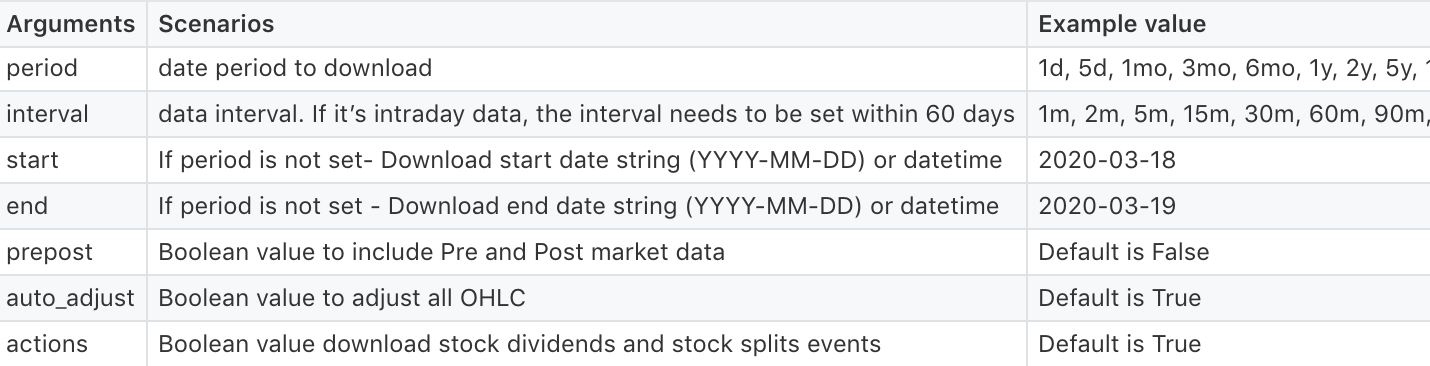

In [89]:
# Download stock data then export as CSV
data_df = yf.download("CL=F", period="max", interval="15m", start="2020-10-01", end="2020-10-31")
data_df.to_csv('WTI.csv')

NameError: name 'yf' is not defined

In [90]:
df_WTI = pd.read_csv('/Users/kenotsu/Documents/データサイエンス学習用/Master_Thesis/WTI.csv', sep=',', header=0)
df_WTI.tail()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenotsu/Documents/データサイエンス学習用/Master_Thesis/WTI.csv'

# Make all_data

一旦とにかくすべてをくっつける

## ※ Half Hourly time slot

時間の切上げ切り捨てについて
https://www.deep-rain.com/programming/python/1355#i-4

all_dataを作る <p>
Aggregate each data of train set based on shop_id, item_id and date_block_num

In [91]:
# Make a table for QH_number
df_intra_HH = df_intra.reset_index()
HH_table = pd.DataFrame(df_intra_HH["HH"])
HH_table = HH_table.drop_duplicates()
HH_table['Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').strftime('%H:%M')
HH_table['Time'] = pd.to_datetime(HH_table['Time']).dt.time
# HH_table['Hourly_Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').floor("H").strftime('%H:%M')
# HH_table['Hourly_Time'] = pd.to_datetime(HH_table['Hourly_Time']).dt.time

HH_table.head()

,HH,Time
0,1,00:00:00
1,2,00:30:00
2,3,01:00:00
3,4,01:30:00
4,5,02:00:00


## Merge all input data

In [92]:
all_data = df_intra

# HH_table
all_data = pd.merge(all_data, HH_table, how="left", on=['HH'])

# df_spot
all_data = pd.merge(all_data, df_spot, how="left", on=['Date', 'HH'])

#df_weather_all
all_data = pd.merge(all_data, df_weather_all, how="left", on=['Date', 'Time'])

#df_actual_generation_Tohoku
all_data = pd.merge(all_data, df_actual_generation_Tohoku, how="left", on=['Date', 'Time'])

#df_HourlyDemand_All
all_data = pd.merge(all_data, df_HourlyDemand_All, how="left", on=['Date', 'Time'])

#df_DemandPlant_tohoku
all_data = pd.merge(all_data, df_DemandPlant_tohoku, how="left", on=['Date', 'Time'])

#df_DemandMin_Tohoku
all_data = pd.merge(all_data, df_DemandMin_Tohoku, how="left", on=['Date', 'Time'])

#df_DemandMax_Tohoku
all_data = pd.merge(all_data, df_DemandMax_Tohoku, how="left", on=['Date', 'Time'])

all_data.head()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count),Time,...,Water(MWh),Thermal(MWh),Actual_Solar(MWh),Actual_Wind(MWh),Geothermal(MWh),Biomass(MWh),PumpedStorage(MWh),Interconnection(MWh),Planned_Min_flag,Planned_Max_flag
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00,...,1812.0,8072.0,0.0,46.0,116.0,41.0,0.0,-2200.0,NaN,NaN
1,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00,...,1812.0,8072.0,0.0,46.0,116.0,41.0,0.0,-2200.0,NaN,NaN
2,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00,...,1812.0,8072.0,0.0,46.0,116.0,41.0,0.0,-2200.0,NaN,NaN
3,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00,...,1812.0,8072.0,0.0,46.0,116.0,41.0,0.0,-2200.0,NaN,NaN
4,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00,...,1812.0,8072.0,0.0,46.0,116.0,41.0,0.0,-2200.0,NaN,NaN


In [93]:
all_data.shape

(124208, 76)

- 基本全部見直し！！

①先にこちらを処理
Generation --> 2016年4月〜2016年7月が欠損。0にて補完 <p>
フラグ --> フラグ以外は欠損のため0で埋める <p>
    
②残りはまとめて処理
Price data --> データ欠損であるが連続性を保持するため直前参照 <p>
Weather --> 30分値欠損のため直前参照 <p>
需要電力量 --> 30分値欠損のため直前参照　+ 20204Qデータ未入手<p>

In [94]:
# Fillna with 0 for Generation and flag
all_data["gen_Solar(mkW)"].fillna(0, inplace=True)
all_data["gen_all(mkW)"].fillna(0, inplace=True)
all_data["gen_Wind(mkW)"].fillna(0, inplace=True)
all_data["Planned_Min_flag"].fillna(0, inplace=True)
all_data["Planned_Max_flag"].fillna(0, inplace=True)

In [95]:
# Fillna with the value of the previous slots for Price, Weather, Demend
all_data.fillna(method='bfill', inplace=True)

In [96]:
# Demand 20204Qデータ未入手のため一旦0で補完
all_data.fillna(0, inplace=True)

In [97]:
print(all_data.isnull().sum())

Date                    0
HH                      0
Open                    0
High                    0
Low                     0
                       ..
Biomass(MWh)            0
PumpedStorage(MWh)      0
Interconnection(MWh)    0
Planned_Min_flag        0
Planned_Max_flag        0
Length: 76, dtype: int64


In [98]:
# Create a column for "date block num"
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data["date_block_num"] = np.trunc(all_data['Date'].map(pd.Timestamp.timestamp).astype(int) / 86400 - 16891)

※ Filter all_data from 2016-04-01 to 2020-12-31

In [99]:
all_data = all_data[all_data["Date"] <= "2020-12-31"]

In [100]:
all_data['month'] = pd.to_datetime(all_data["Date"]).dt.month

In [101]:
all_data = all_data.drop('Date', axis=1)
all_data = all_data.drop('Time', axis=1)

In [102]:
all_data.tail()

,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count),Sell_volume(kWh),Buy_volume(kWh),...,Actual_Solar(MWh),Actual_Wind(MWh),Geothermal(MWh),Biomass(MWh),PumpedStorage(MWh),Interconnection(MWh),Planned_Min_flag,Planned_Max_flag,date_block_num,month
123250,44,35.0,70.0,33.00,70.00,44.71,328.7,110,16913450,22563500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1736.0,12
123251,45,42.0,70.0,41.01,45.48,50.19,409.9,104,16406450,22394500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1736.0,12
123252,46,42.0,70.0,35.00,41.33,42.20,383.2,112,16501300,21888250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1736.0,12
123253,47,37.0,70.0,33.93,36.66,44.09,345.9,60,16224050,21729250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1736.0,12
123254,48,27.0,37.5,23.93,26.46,28.42,233.3,66,16207050,21202500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1736.0,12


In [103]:
all_data.shape

(123255, 76)

# Data leakage(Predictionポイントは前日の16:30とする)
Volumu確認後、当日の0:00にする可能性もあり

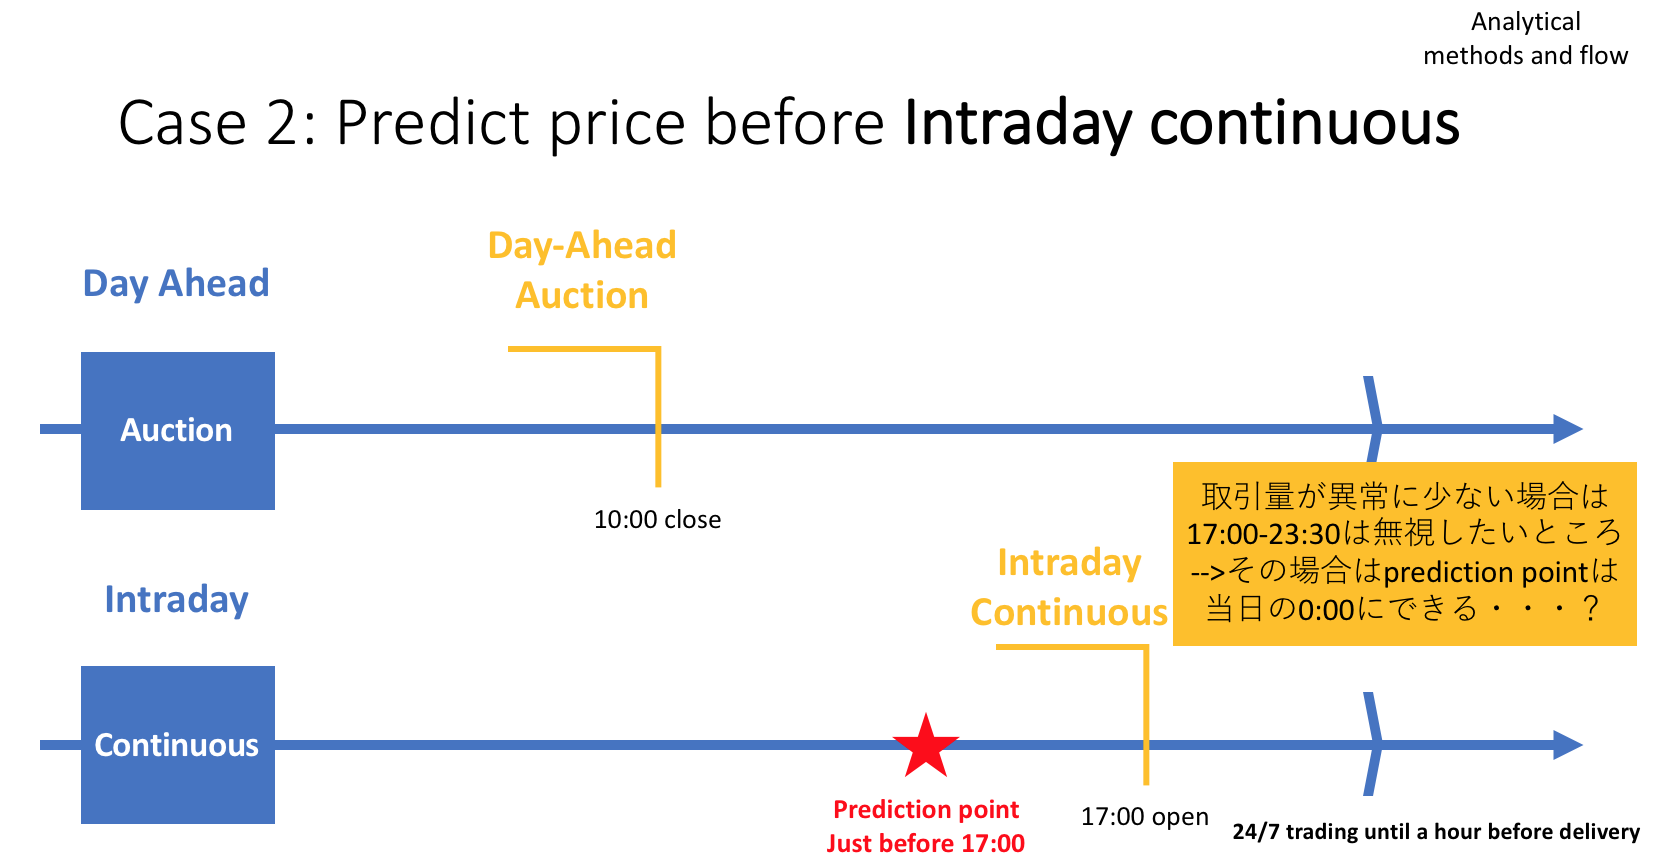

予測時点でどの特徴量が存在しうるか整理する

- Close priceは外す (Target) 
- Spot_price & volume: そのまま(Spot価格確定後の予測)
- 電力需要ピーク情報: そのまま（翌日予測）
- その他: <p>
    ① block_date_numを１日分だけずらす (Prediction pointを0:00直前に変更する)<p>
        ※ここでの論点はIntraday開始直後に取引される17:00から24:00までのアイテムだが、取引量は少ないと仮定して一旦は取引を無視する。(もう少し整理が必要)
        
    
    その上で更に、<p>
    ② HHを1スロット分ずらす <p>
    ③ その他はseasonality検証後に必要に応じて追加 <p>
    ④ lag_feature生成後元の特徴量は全て削除 <p>

※欠損値は0でないほうがいい --> 削除？　要検証

# Feature Engineering

<EDA前にやること><p>
【時系列分析の基本】定常性とホワイトノイズを分かりすく解説 <p>
https://ai-trend.jp/basic-study/time-series-analysis/time-series-analysis-stationaly-noise/
    
時系列データに定常性を持たせて解析する方法
https://ai-trend.jp/basic-study/time-series-analysis/stationarity/

機械学習による株価予測　いろはの”い”
https://qiita.com/blog_UKI/items/25dc1c2559c61890a449

## Mean encoding (共通のグループの平均値などの)一旦スキップ

[Mean Encoding without regularization]

In [104]:
# # # Calculate a mapping: {item_id: target_mean}
# all_data2 = all_data
# item_id_target_mean = all_data2.groupby('item_id').item_cnt_month.mean()

# # In our non-regularized case we just *map* the computed means to the `item_id`'s
# all_data2['item_target_enc1'] = all_data2['item_id'].map(item_id_target_mean)

# # Fill NaNs
# all_data2['item_target_enc1'].fillna(0.3343, inplace=True) 

# # Print correlation
# encoded_feature = all_data2['item_target_enc1'].values
# print(np.corrcoef(all_data2['item_cnt_month'].values, encoded_feature)[0][1])

[Expanding mean scheme]

In [105]:
# %time

# cumsum = all_data2.groupby('item_id')['item_cnt_month'].cumsum() - all_data2['item_cnt_month']
# cumcnt = all_data2.groupby('item_id').cumcount()

# all_data2['item_target_enc2'] = cumsum / cumcnt
# all_data2['item_target_enc2'].fillna(0.3343, inplace=True)
# encoded_feature = all_data2['item_target_enc2'].values

# corr = np.corrcoef(all_data2['item_cnt_month'].values, encoded_feature)[0][1]
# print(corr)

※一旦全てにラグ特徴量を適用する
 -->ただし、計算コストを下げるために可能であれば、ここで特徴量間の相関が高いものは排除する (天気データなど)

In [ ]:
# Reduce the number of features which have high correlation each other
#all_data = all_data.drop(df.all_data[df.all_data.str.contains('' or '' or '')], axis=1)

## Avoid Data leakage with Lag-features (ラグ特徴量)

※Infinity value will be happen with Downcast preprocessing. ("Total" column)

In [326]:
# from tqdm import tqdm_notebook

# def downcast_dtypes(df):
#     '''
#         Changes column types in the dataframe: 
                
#                 `float64` type to `float32`
#                 `int64`   type to `int32`
#     '''
    
#     # Select columns to downcast
#     float_cols = [c for c in df if df[c].dtype == "float64"]
#     int_cols =   [c for c in df if df[c].dtype == "int64"]
    
#     # Downcast
#     df[float_cols] = df[float_cols].astype(np.float16)
#     df[int_cols]   = df[int_cols].astype(np.int16)
    
#     return df

In [274]:
# def fill_na(df):
#     for col in df.columns:
#         if ('_lag_' in col) & (df[col].isnull().any()):
#             df[col].fillna(0, inplace=True)         
#     return df

In [327]:
# all_data = downcast_dtypes(all_data)

In [286]:
# Delete the dataframe that will not be used in order to save the memory on PC
# del df_train

In [106]:
# Check the remaining memory on PC
import gc
gc.collect()

133

※ ラグ特徴量が必要ないものと"Close"(target)は外す

In [107]:
lag_columns = all_data.columns.drop(['HH', 'Close', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Tohoku(Yen/kWh)',
       'Price_Tokyo(Yen/kWh)', 'Planned_Min_flag', 'Planned_Max_flag',
       'date_block_num', 'month'])

In [108]:
lag_columns

Index(['Open', 'High', 'Low', 'Average', 'Volume(MWh/h)', 'Volume(Tick count)',
       'Temp_Ao', 'SunLight(Time)_Ao', 'WindSpeed(m/s)_Ao', 'WindDirection_Ao',
       'SunLight(MJ/㎡)_Ao', 'Temp_Aki', 'SunLight(Time)_Aki',
       'WindSpeed(m/s)_Aki', 'WindDirection_Aki', 'SunLight(MJ/㎡)_Aki',
       'Temp_Mo', 'SunLight(Time)_Mo', 'WindSpeed(m/s)_Mo', 'WindDirection_Mo',
       'SunLight(MJ/㎡)_Mo', 'Temp_Ya', 'SunLight(Time)_Ya',
       'WindSpeed(m/s)_Ya', 'WindDirection_Ya', 'SunLight(MJ/㎡)_Ya', 'Temp_Se',
       'SunLight(Time)_Se', 'WindSpeed(m/s)_Se', 'WindDirection_Se',
       'SunLight(MJ/㎡)_Se', 'Temp_Fu', 'SunLight(Time)_Fu',
       'WindSpeed(m/s)_Fu', 'WindDirection_Fu', 'SunLight(MJ/㎡)_Fu', 'Temp_Ni',
       'SunLight(Time)_Ni', 'WindSpeed(m/s)_Ni', 'WindDirection_Ni',
       'SunLight(MJ/㎡)_Ni', 'gen_all(mkW)', 'gen_Solar(mkW)', 'gen_Wind(mkW)',
       'Hokkaido', 'Tohoku', 'Tokyo', 'Chubu', 'Hokuriku', 'Kansai', 'Chugoku',
       'Shikoku', 'Kyushu', 'Okinawa', 'Total', '

厳密にすると、17:00〜23:30は予測時点では１日前の情報は手に入らない
Prediction pointを「前日の17:00直前」とする場合は、以下の手当が必要
予測時点の前後でDaylag1とDaylag2の参照を変える
もともとのカラムに格納し、カラム名を変更する
Daylag1とDaylag2を削除する

※一旦はPrediction pointを当日0:00直前とし、スキップする (前日の17:00〜23:59の取引は少ないものと仮定する)

In [109]:
def generate_lag_day(train, days, cols):
   
    for col in cols:
        for day in days:
           # copy the columns that need to generate lag features
            train_shift = train[['date_block_num', 'HH', col]].copy()

            # Change the name of  lag features
            train_shift.columns = ['date_block_num', 'HH', col+'_Daylag_'+ str(day)]
            train_shift['date_block_num'] += day
            train = pd.merge(train, train_shift, how='left', on=['date_block_num', 'HH'])
   
    return train

In [ ]:
all_data_lagged = generate_lag_day(all_data, [1], lag_columns)

In [ ]:
all_data_lagged = all_data_lagged.drop(lag_columns, axis=1)

In [ ]:
print(all_data_lagged.isnull().sum().head(20))

NaN was generated only on 48 timeslots on the firstday 2016/04/01 --> OK 

In [ ]:
all_data_lagged.fillna(0, inplace=True)
print(all_data_lagged.isnull().sum().head(20))

In [ ]:
all_data_lagged.tail()

In [ ]:
# # 考えられるループ (必要に応じて作成する)
# def daylag_rename(train, HHs, cols):
#     #　カラムを１つずつ取得
#     for col in cols:
#         train = train[['date_block_num', 'HH', col]].copy()
#         train.columns = ['date_block_num', 'HH', col+'_Daylag']

# def adjust_lag(train, HHs, cols):
#     #　カラムを１つずつ取得
#     for col in cols:
#         # HHを１つずつ取得
#         for HH in HHs:
#             # HHが35(17:00)以上48(23:30)以下であれば
#             if 35 <= HH >=48:
#                 ２日前のデータを参照
#             else:
#                 １日前のデータ参照

#             # Change the name of  lag features
#             train_shift.columns = ['date_block_num', 'HH', col+'_Daylag']
#             train_shift['HH'] += HH
            
#             # Adjust HH
#             for i in train['HH']:
#                 if i == 49:
#                     train_shift['HH'] == 1
#                     train_shift['date_block_num'] += 1

# 定義実行
# all_data_lagged = generate_lag_day(all_data_lagged, [1, 2], lag_columns)

#欠損値を確認
# print(all_data_lagged.isnull().sum())

# "Daylag"カラムに数値が反映されていることをかくにんしたら、Daylag_1とDay_lag2は削除
#all_data = all_data.drop(df.all_data[df.all_data.str.contains('Daylag_1' or 'Day_lag2' )], axis=1)

In [ ]:
def generate_lag_HH(train, HHs, cols):
    for col in cols:

        for HH in HHs:
            # copy the columns that need to generate lag features
            train_shift = train[['date_block_num', 'HH', col]].copy()

            # Change the name of  lag features
            train_shift.columns = ['date_block_num', 'HH', col+'_HHlag_'+ str(HH)]
            train_shift['HH'] += HH
            
            # Adjust HH
            for i in train['HH']:
                if i == 49:
                    train_shift['HH'] == 1
                    train_shift['date_block_num'] += 1

            # Merge lagged features into the original df
            train = pd.merge(train, train_shift, how='left', on=['date_block_num', 'HH'])
    return train

※ラグ特徴量が必要ないものと"Close"(target)は再度外す

In [ ]:
lag_columns = all_data_lagged.columns.drop(['HH', 'Close', 'Sell_volume(kWh)', 'Buy_volume(kWh)',
       'Total_volume(kWh)', 'System_price(Yen/kWh)', 'Price_Tohoku(Yen/kWh)',
       'Price_Tokyo(Yen/kWh)', 'Planned_Min_flag', 'Planned_Max_flag',
       'date_block_num', 'month'])

In [ ]:
lag_columns

In [ ]:
# Generate lag for 48h(1day) and 49h(1day + 1 slot) before
all_data_lagged = generate_lag_HH(all_data_lagged, [1], lag_columns)

In [ ]:
print(all_data_lagged.isnull().sum().tail())

In [ ]:
all_data_lagged.fillna(0, inplace=True)
print(all_data_lagged.isnull().sum().tail())

In [ ]:
print(all_data_lagged.isnull().sum().head(5))

In [ ]:
all_data_lagged.columns

## Month, Holiday

休日設定が必要であればここで調整
※一旦スキップ

In [ ]:
# holiday_dict = {
#     0: 6,
#     1: 3,
#     2: 2,
#     3: 8,
#     4: 3,
#     5: 3,
#     6: 2,
#     7: 8,
#     8: 4,
#     9: 8,
#     10: 5,
#     11: 4,
# }

In [ ]:
#all_data['holidays_in_month'] = all_data['month'].map(holiday_dict)

## Standardise with Log-features (対数化)

In [ ]:
all_data_lagged.info()

In [ ]:
all_data_log1 = all_data_lagged[['HH', 'date_block_num', 'month', 'Planned_Min_flag', 'Planned_Max_flag']]
all_data_log2 = all_data_lagged.drop(['HH', 'date_block_num', 'month', 'Planned_Min_flag', 'Planned_Max_flag'], axis=1)

In [ ]:
all_data_log2.head()

In [ ]:
cols = all_data_log2.columns

In [ ]:
# logarithmic transformation for standardised
# 0と負の値を含む列があるので、PowerTransformer()のYeo-Johnson変換を適用する (対数変換の一種)
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
pt.fit(all_data_log2[cols])
all_data_log2[cols] = pt.transform(all_data_log2[cols])

In [ ]:
all_data_log = pd.concat([all_data_log1, all_data_log2], axis=1)

※If PowerTransformer does not work due to infinity value, the following process must be implemented.

In [ ]:
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

In [ ]:
# Searching infinity value
# a = all_data_lagged.replace([np.inf, -np.inf], np.nan)
# print(a.isnull().sum().head(150))

In [ ]:
# all_data_lagged_2 = all_data_lagged_2.drop(["Total_Daylag_1", "Total_Daylag_1_HHlag_1"], axis=1)
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

※ Inverse_transform(逆対数変換)についても調べる！！　予測後のClose priceを元の数値に戻す必要がある！！

# EDA (for all_data)

In [ ]:
all_data_log.head()

## Check the Correlation between features
    -->相関が極めて高いものはグルーピングして訓練データ内でダブらないようにする


In [ ]:
# correlation matrix
corrmat = all_data_log.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True);

## Check the correlation of features with the target
    -->上位相関(正と負)はピックアップして更に数値にしてみる

In [ ]:
# revenue correlation matrix
k = 10 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(all_data_log[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# scatterplot
sns.set()
cols = ['Close', 'System_price(Yen/kWh)', 'Price_Tohoku(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 'Average_Daylag_1', 'Low_Daylag_1', 'Open_Daylag_1', 'High_Daylag_1', 'Average_Daylag_1_HHlag_1']
sns.pairplot(all_data_log[cols], size=2.5)
plt.show()

<メモ><p>
    - 外れ値は見られるが線形の関係が見られる <p>
    - OpenとCloseの相関は見られないが、OpenとHighはなぜか相関が高い。（Openで高値がつきやすい？） <p>
    - TokyoとTohokuは高い相関が見られる

外れ値はここで処理しておく --> ただし一概に外れ値を除去するべきとは限らない。要検討 <P>
全体のEDAで気になる点がでれば個別にEDA

In [264]:
# Remove the ourliers 
# all_data = all_data[all_data.item_price<60000]

In [ ]:
# Re-confirm the outliers with scatter plot
# var = "item_price"
# data = pd.concat([all_data['item_cnt_month'], all_data[var]], axis=1)
# data.plot.scatter(x=var, y='item_cnt_month', ylim=(0,100));

Chack time series trend on the data set

In [251]:
# # Pick up one sample shop_id and item_id
# all_data_plot = all_data[all_data['shop_id'] == 25]
# all_data_plot = all_data_plot[all_data_plot['item_id'] == 5037]
# all_data_plot.head()

,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id
503154,20,9.0,5037,2599.0,25,19
503155,21,5.0,5037,2599.0,25,19
503156,22,2.0,5037,2599.0,25,19
503157,23,7.0,5037,2239.0,25,19
503158,24,3.0,5037,1999.0,25,19


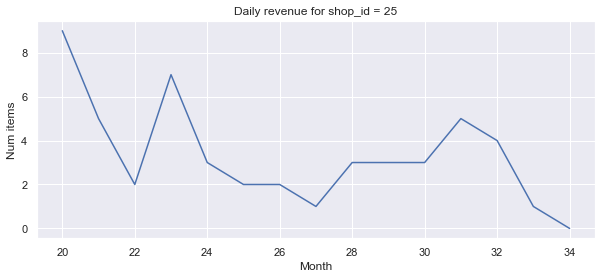

In [252]:
# plt.figure(figsize=(10,4))
# # Plot it
# plt.ylabel('Num items')
# plt.xlabel('Month')
# plt.title("Daily revenue for shop_id = 25")
# plt.plot(all_data_plot['date_block_num'], all_data_plot['item_cnt_month']);
# plt.show()

## 各特徴量の再調整

外れ値を削除 or 残す
EDAの結果を見て不要な特徴量は削除 (特徴量間の相関が高いもの、目的関数との相関がないものを除外)

# Training Models with "all_data"

モデル訓練の前に必ず整理すること！！

- target --> Close <p>
- date_block_num --> train < 1736, test == 1736 (実際は10 holds validation)<p>
    
< Data leakage (re-confirming) >
- price --> unpredictable --> remove <p>

In [593]:
all_data_log['date_block_num'].describe()

count    83328.000000
mean       868.500000
std        501.142958
min          1.000000
25%        434.750000
50%        868.500000
75%       1302.250000
max       1736.000000
Name: date_block_num, dtype: float64

In [592]:
#整理後のtraining data
all_data_log.tail()

,HH,date_block_num,month,Planned_Min_flag,Planned_Max_flag,Close,Sell_volume(kWh),Buy_volume(kWh),Total_volume(kWh),System_price(Yen/kWh),Price_Tohoku(Yen/kWh),Price_Tokyo(Yen/kWh),Open_Daylag_1,High_Daylag_1,Low_Daylag_1,Average_Daylag_1,Volume(MWh/h)_Daylag_1,Volume(Tick count)_Daylag_1,Temp_Ao_Daylag_1,SunLight(Time)_Ao_Daylag_1,WindSpeed(m/s)_Ao_Daylag_1,WindDirection_Ao_Daylag_1,SunLight(MJ/㎡)_Ao_Daylag_1,Temp_Aki_Daylag_1,SunLight(Time)_Aki_Daylag_1,WindSpeed(m/s)_Aki_Daylag_1,WindDirection_Aki_Daylag_1,SunLight(MJ/㎡)_Aki_Daylag_1,Temp_Mo_Daylag_1,SunLight(Time)_Mo_Daylag_1,WindSpeed(m/s)_Mo_Daylag_1,WindDirection_Mo_Daylag_1,SunLight(MJ/㎡)_Mo_Daylag_1,Temp_Ya_Daylag_1,SunLight(Time)_Ya_Daylag_1,WindSpeed(m/s)_Ya_Daylag_1,WindDirection_Ya_Daylag_1,SunLight(MJ/㎡)_Ya_Daylag_1,Temp_Se_Daylag_1,SunLight(Time)_Se_Daylag_1,WindSpeed(m/s)_Se_Daylag_1,WindDirection_Se_Daylag_1,SunLight(MJ/㎡)_Se_Daylag_1,Temp_Fu_Daylag_1,SunLight(Time)_Fu_Daylag_1,WindSpeed(m/s)_Fu_Daylag_1,WindDirection_Fu_Daylag_1,SunLight(MJ/㎡)_Fu_Daylag_1,Temp_Ni_Daylag_1,SunLight(Time)_Ni_Daylag_1,WindSpeed(m/s)_Ni_Daylag_1,WindDirection_Ni_Daylag_1,SunLight(MJ/㎡)_Ni_Daylag_1,gen_Solar(mkW)_Daylag_1,gen_all(mkW)_Daylag_1,gen_Wind(mkW)_Daylag_1,Hokkaido_Daylag_1,Tohoku_Daylag_1,Tokyo_Daylag_1,Chubu_Daylag_1,Hokuriku_Daylag_1,Kansai_Daylag_1,Chugoku_Daylag_1,Shikoku_Daylag_1,Kyushu_Daylag_1,Okinawa_Daylag_1,Total_Daylag_1,AreaDemand(MWh)_Daylag_1,Water(MWh)_Daylag_1,Thermal(MWh)_Daylag_1,Actual_Solar(MWh)_Daylag_1,Actual_Wind(MWh)_Daylag_1,Geothermal(MWh)_Daylag_1,Biomass(MWh)_Daylag_1,PumpedStorage(MWh)_Daylag_1,Interconnection(MWh)_Daylag_1,Open_Daylag_1_HHlag_1,High_Daylag_1_HHlag_1,Low_Daylag_1_HHlag_1,Average_Daylag_1_HHlag_1,Volume(MWh/h)_Daylag_1_HHlag_1,Volume(Tick count)_Daylag_1_HHlag_1,Temp_Ao_Daylag_1_HHlag_1,SunLight(Time)_Ao_Daylag_1_HHlag_1,WindSpeed(m/s)_Ao_Daylag_1_HHlag_1,WindDirection_Ao_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ao_Daylag_1_HHlag_1,Temp_Aki_Daylag_1_HHlag_1,SunLight(Time)_Aki_Daylag_1_HHlag_1,WindSpeed(m/s)_Aki_Daylag_1_HHlag_1,WindDirection_Aki_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Aki_Daylag_1_HHlag_1,Temp_Mo_Daylag_1_HHlag_1,SunLight(Time)_Mo_Daylag_1_HHlag_1,WindSpeed(m/s)_Mo_Daylag_1_HHlag_1,WindDirection_Mo_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Mo_Daylag_1_HHlag_1,Temp_Ya_Daylag_1_HHlag_1,SunLight(Time)_Ya_Daylag_1_HHlag_1,WindSpeed(m/s)_Ya_Daylag_1_HHlag_1,WindDirection_Ya_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ya_Daylag_1_HHlag_1,Temp_Se_Daylag_1_HHlag_1,SunLight(Time)_Se_Daylag_1_HHlag_1,WindSpeed(m/s)_Se_Daylag_1_HHlag_1,WindDirection_Se_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Se_Daylag_1_HHlag_1,Temp_Fu_Daylag_1_HHlag_1,SunLight(Time)_Fu_Daylag_1_HHlag_1,WindSpeed(m/s)_Fu_Daylag_1_HHlag_1,WindDirection_Fu_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Fu_Daylag_1_HHlag_1,Temp_Ni_Daylag_1_HHlag_1,SunLight(Time)_Ni_Daylag_1_HHlag_1,WindSpeed(m/s)_Ni_Daylag_1_HHlag_1,WindDirection_Ni_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ni_Daylag_1_HHlag_1,gen_Solar(mkW)_Daylag_1_HHlag_1,gen_all(mkW)_Daylag_1_HHlag_1,gen_Wind(mkW)_Daylag_1_HHlag_1,Hokkaido_Daylag_1_HHlag_1,Tohoku_Daylag_1_HHlag_1,Tokyo_Daylag_1_HHlag_1,Chubu_Daylag_1_HHlag_1,Hokuriku_Daylag_1_HHlag_1,Kansai_Daylag_1_HHlag_1,Chugoku_Daylag_1_HHlag_1,Shikoku_Daylag_1_HHlag_1,Kyushu_Daylag_1_HHlag_1,Okinawa_Daylag_1_HHlag_1,Total_Daylag_1_HHlag_1,AreaDemand(MWh)_Daylag_1_HHlag_1,Water(MWh)_Daylag_1_HHlag_1,Thermal(MWh)_Daylag_1_HHlag_1,Actual_Solar(MWh)_Daylag_1_HHlag_1,Actual_Wind(MWh)_Daylag_1_HHlag_1,Geothermal(MWh)_Daylag_1_HHlag_1,Biomass(MWh)_Daylag_1_HHlag_1,PumpedStorage(MWh)_Daylag_1_HHlag_1,Interconnection(MWh)_Daylag_1_HHlag_1
83323,44,1736.0,12,0.0,0.0,5.569498,0.516615,1.185998,0.974389,4.056114,3.357070,3.248023,3.805594,3.016713,5.152820,4.164002,0.963385,1.903583,-1.912099,-0.631158,1.763438,1.186080,-0.852521,-2.156573,-0.620137,1.233756,1.317352,-0.843218,-1.672878,-0.633052,0.570563,1.353842,-0.85496,-1.917869,-0.631661,-0.374585,1.151051,-0.859206,-1.792305,-0.656124,2.355026,0.891459,-0.855185,-1.757345,-

In [618]:
all_data_log.shape

(83328, 140)

Split all_data set based on time-base

In [594]:
# Organise the order of columns
all_train = all_data_log[all_data_log["date_block_num"] < 1736]
all_valid = all_data_log[all_data_log["date_block_num"] == 1736]

x_train = all_train.drop(['Close'], axis=1)
y_train = all_train.Close
x_valid = all_valid.drop(['Close'], axis=1)
y_valid = all_valid.Close

In [595]:
x_train.tail()

,HH,date_block_num,month,Planned_Min_flag,Planned_Max_flag,Sell_volume(kWh),Buy_volume(kWh),Total_volume(kWh),System_price(Yen/kWh),Price_Tohoku(Yen/kWh),Price_Tokyo(Yen/kWh),Open_Daylag_1,High_Daylag_1,Low_Daylag_1,Average_Daylag_1,Volume(MWh/h)_Daylag_1,Volume(Tick count)_Daylag_1,Temp_Ao_Daylag_1,SunLight(Time)_Ao_Daylag_1,WindSpeed(m/s)_Ao_Daylag_1,WindDirection_Ao_Daylag_1,SunLight(MJ/㎡)_Ao_Daylag_1,Temp_Aki_Daylag_1,SunLight(Time)_Aki_Daylag_1,WindSpeed(m/s)_Aki_Daylag_1,WindDirection_Aki_Daylag_1,SunLight(MJ/㎡)_Aki_Daylag_1,Temp_Mo_Daylag_1,SunLight(Time)_Mo_Daylag_1,WindSpeed(m/s)_Mo_Daylag_1,WindDirection_Mo_Daylag_1,SunLight(MJ/㎡)_Mo_Daylag_1,Temp_Ya_Daylag_1,SunLight(Time)_Ya_Daylag_1,WindSpeed(m/s)_Ya_Daylag_1,WindDirection_Ya_Daylag_1,SunLight(MJ/㎡)_Ya_Daylag_1,Temp_Se_Daylag_1,SunLight(Time)_Se_Daylag_1,WindSpeed(m/s)_Se_Daylag_1,WindDirection_Se_Daylag_1,SunLight(MJ/㎡)_Se_Daylag_1,Temp_Fu_Daylag_1,SunLight(Time)_Fu_Daylag_1,WindSpeed(m/s)_Fu_Daylag_1,WindDirection_Fu_Daylag_1,SunLight(MJ/㎡)_Fu_Daylag_1,Temp_Ni_Daylag_1,SunLight(Time)_Ni_Daylag_1,WindSpeed(m/s)_Ni_Daylag_1,WindDirection_Ni_Daylag_1,SunLight(MJ/㎡)_Ni_Daylag_1,gen_Solar(mkW)_Daylag_1,gen_all(mkW)_Daylag_1,gen_Wind(mkW)_Daylag_1,Hokkaido_Daylag_1,Tohoku_Daylag_1,Tokyo_Daylag_1,Chubu_Daylag_1,Hokuriku_Daylag_1,Kansai_Daylag_1,Chugoku_Daylag_1,Shikoku_Daylag_1,Kyushu_Daylag_1,Okinawa_Daylag_1,Total_Daylag_1,AreaDemand(MWh)_Daylag_1,Water(MWh)_Daylag_1,Thermal(MWh)_Daylag_1,Actual_Solar(MWh)_Daylag_1,Actual_Wind(MWh)_Daylag_1,Geothermal(MWh)_Daylag_1,Biomass(MWh)_Daylag_1,PumpedStorage(MWh)_Daylag_1,Interconnection(MWh)_Daylag_1,Open_Daylag_1_HHlag_1,High_Daylag_1_HHlag_1,Low_Daylag_1_HHlag_1,Average_Daylag_1_HHlag_1,Volume(MWh/h)_Daylag_1_HHlag_1,Volume(Tick count)_Daylag_1_HHlag_1,Temp_Ao_Daylag_1_HHlag_1,SunLight(Time)_Ao_Daylag_1_HHlag_1,WindSpeed(m/s)_Ao_Daylag_1_HHlag_1,WindDirection_Ao_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ao_Daylag_1_HHlag_1,Temp_Aki_Daylag_1_HHlag_1,SunLight(Time)_Aki_Daylag_1_HHlag_1,WindSpeed(m/s)_Aki_Daylag_1_HHlag_1,WindDirection_Aki_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Aki_Daylag_1_HHlag_1,Temp_Mo_Daylag_1_HHlag_1,SunLight(Time)_Mo_Daylag_1_HHlag_1,WindSpeed(m/s)_Mo_Daylag_1_HHlag_1,WindDirection_Mo_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Mo_Daylag_1_HHlag_1,Temp_Ya_Daylag_1_HHlag_1,SunLight(Time)_Ya_Daylag_1_HHlag_1,WindSpeed(m/s)_Ya_Daylag_1_HHlag_1,WindDirection_Ya_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ya_Daylag_1_HHlag_1,Temp_Se_Daylag_1_HHlag_1,SunLight(Time)_Se_Daylag_1_HHlag_1,WindSpeed(m/s)_Se_Daylag_1_HHlag_1,WindDirection_Se_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Se_Daylag_1_HHlag_1,Temp_Fu_Daylag_1_HHlag_1,SunLight(Time)_Fu_Daylag_1_HHlag_1,WindSpeed(m/s)_Fu_Daylag_1_HHlag_1,WindDirection_Fu_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Fu_Daylag_1_HHlag_1,Temp_Ni_Daylag_1_HHlag_1,SunLight(Time)_Ni_Daylag_1_HHlag_1,WindSpeed(m/s)_Ni_Daylag_1_HHlag_1,WindDirection_Ni_Daylag_1_HHlag_1,SunLight(MJ/㎡)_Ni_Daylag_1_HHlag_1,gen_Solar(mkW)_Daylag_1_HHlag_1,gen_all(mkW)_Daylag_1_HHlag_1,gen_Wind(mkW)_Daylag_1_HHlag_1,Hokkaido_Daylag_1_HHlag_1,Tohoku_Daylag_1_HHlag_1,Tokyo_Daylag_1_HHlag_1,Chubu_Daylag_1_HHlag_1,Hokuriku_Daylag_1_HHlag_1,Kansai_Daylag_1_HHlag_1,Chugoku_Daylag_1_HHlag_1,Shikoku_Daylag_1_HHlag_1,Kyushu_Daylag_1_HHlag_1,Okinawa_Daylag_1_HHlag_1,Total_Daylag_1_HHlag_1,AreaDemand(MWh)_Daylag_1_HHlag_1,Water(MWh)_Daylag_1_HHlag_1,Thermal(MWh)_Daylag_1_HHlag_1,Actual_Solar(MWh)_Daylag_1_HHlag_1,Actual_Wind(MWh)_Daylag_1_HHlag_1,Geothermal(MWh)_Daylag_1_HHlag_1,Biomass(MWh)_Daylag_1_HHlag_1,PumpedStorage(MWh)_Daylag_1_HHlag_1,Interconnection(MWh)_Daylag_1_HHlag_1
83275,44,1735.0,12,0.0,0.0,0.498903,1.185348,0.962087,5.137080,4.088559,3.897944,2.921211,2.246867,2.444693,2.978856,1.594187,1.870100,-1.230553,-0.631158,-0.255509,-1.580764,-0.852521,-1.004245,-0.620137,0.274755,-0.437446,-0.843218,-0.883643,-0.633052,0.859296,-0.029989,-0.85496,-1.166931,-0.631661,-0.374585,0.436779,-0.859206,-1.158367,-0.656124,-0.444117,0.104712,-0.855185,-1.230405,-0.640212,-

In [684]:
x_train.shape

(83280, 139)

In [597]:
y_train.head()

0   -0.074514
1   -0.223023
2   -0.223023
3   -0.271172
4   -0.223023
Name: Close, dtype: float64

In [685]:
x_valid.shape

(48, 139)

In [599]:
print(x_valid.isnull().sum())

HH                                       0
date_block_num                           0
month                                    0
Planned_Min_flag                         0
Planned_Max_flag                         0
Sell_volume(kWh)                         0
Buy_volume(kWh)                          0
Total_volume(kWh)                        0
System_price(Yen/kWh)                    0
Price_Tohoku(Yen/kWh)                    0
Price_Tokyo(Yen/kWh)                     0
Open_Daylag_1                            0
High_Daylag_1                            0
Low_Daylag_1                             0
Average_Daylag_1                         0
Volume(MWh/h)_Daylag_1                   0
Volume(Tick count)_Daylag_1              0
Temp_Ao_Daylag_1                         0
SunLight(Time)_Ao_Daylag_1               0
WindSpeed(m/s)_Ao_Daylag_1               0
WindDirection_Ao_Daylag_1                0
SunLight(MJ/㎡)_Ao_Daylag_1               0
Temp_Aki_Daylag_1                        0
SunLight(Ti

# Modelling without any adjustment

Document of Prophet from Facebook
https://peerj.com/preprints/3190/

日本語の解説 (公式ではないが結構細かい)
https://mikiokubo.github.io/analytics/15forecast.html

In [605]:
!pip3 install fbprophet

     |████████████████████████████████| 71kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 1.9MB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 39.1MB 234kB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 109kB/s eta 0:00:01
     |████████████████████████████████| 51kB 394kB/s eta 0:00:01
     |████████████████████████████████| 122kB 182kB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 172kB/s eta 0:00:01
     |████████████████████████████████| 737kB 59kB/s eta 0:00:011     |██████████████████████          | 501kB 170kB/s eta 0:00:02
  ERROR: Complete output from command /usr/local/opt/python/bin/python3.7 -u -c 'import setuptools, tokenize;__file__='"'"'/private/var/folders/lh/dxhyckpn2v552fw019vqddx00000gn/T/pip-install-tmt6xjq1/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /priva

  Stored in directory: /Users/kenotsu/Library/Caches/pip/wheels/40/31/ad/edd435075e126fb806bd4dcc6af1c4b5554e53c7562602b51d
  Stored in directory: /Users/kenotsu/Library/Caches/pip/wheels/8d/1a/e7/684cd77a99aac294f976db834fe613b5424f7c4d75ffb0b84d
Successfully built holidays pymeeus
Failed to build fbprophet
ERROR: holidays 0.10.4 has requirement convertdate<=2.2.0, but you'll have convertdate 2.3.0 which is incompatible.
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
      Successfully uninstalled pandas-0.25.1
  Running setup.py install for fbprophet ... done


In [600]:
from sklearn.linear_model import LinearRegression
modelLine = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1).fit(x_train, y_train)

In [601]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor(n_jobs = -1, min_samples_leaf = 5, n_estimators=200).fit(x_train, y_train)

In [602]:
from xgboost import XGBRegressor
modelXGB = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=200, colsample_bytree=0.1).fit(x_train, y_train)

Prophet用にデータを加工する <p>
①日時を残す (YYYYMMDD + Time)にする <p>
②列名を変更 (datetime -->dt, target-->y) <p>
③ date_block_num 1736で分割

In [643]:
all_data["Date"] = all_data["Date"].astype(str)
all_data["Time"] = all_data["Time"].astype(str)

In [653]:
all_data_log ["DateTime"] = pd.to_datetime(all_data["Date"].str.cat( all_data["Time"], sep=" "))

In [721]:
# train dataset for prophet
df_prop = all_data_log.rename(columns={'DateTime': 'ds', 'Close': 'y'})

all_train = df_prop[df_prop["date_block_num"] < 1736]
all_valid = df_prop[df_prop["date_block_num"] == 1736]

y_train = all_train['y']
y_valid = all_valid['y']

In [711]:
from fbprophet import Prophet
modelProp = Prophet().fit(all_train)

periodsパラメータは「カットオフ値」の設定 
--> 設定した数値分行数が増える
-->よくわからないのでとりあえず0

In [713]:
future = modelProp.make_future_dataframe(periods=48, freq= '30min')
future.tail()

,ds
83323,2020-12-31 21:30:00
83324,2020-12-31 22:00:00
83325,2020-12-31 22:30:00
83326,2020-12-31 23:00:00
83327,2020-12-31 23:30:00


In [714]:
forecast = modelProp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
83323,2020-12-31 21:30:00,0.764706,-0.172329,1.695675
83324,2020-12-31 22:00:00,0.679798,-0.235704,1.627158
83325,2020-12-31 22:30:00,0.601978,-0.389200,1.562154
83326,2020-12-31 23:00:00,0.533522,-0.472447,1.522391
83327,2020-12-31 23:30:00,0.477064,-0.518217,1.435262


In [718]:
forecast_train = forecast[forecast.index < 83280]
forecast_valid = forecast[forecast.index >= 83280]

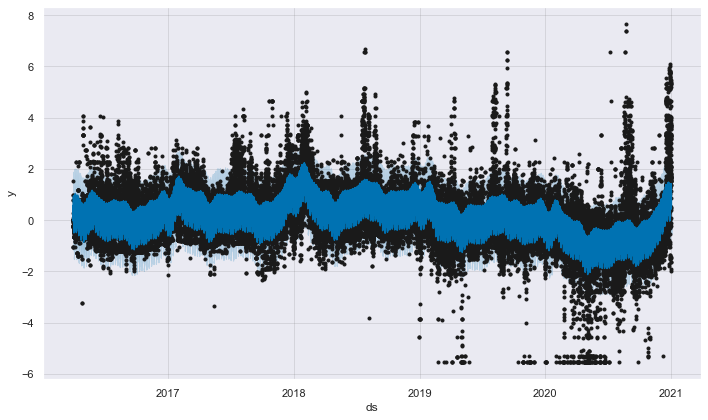

In [726]:
modelProp.plot(forecast);

[RMSE]

In [722]:
y_preds_model_Line = pd.DataFrame(modelLine.predict(x_train)).round()
y_valid_model_Line = pd.DataFrame(modelLine.predict(x_valid)).round()

y_preds_model_RF = pd.DataFrame(modelRF.predict(x_train)).round()
y_valid_model_RF = pd.DataFrame(modelRF.predict(x_valid)).round()

y_preds_model_XGB = pd.DataFrame(modelXGB.predict(x_train)).round()
y_valid_model_XGB = pd.DataFrame(modelXGB.predict(x_valid)).round()

RMSEは元の数値で算出するほうが良さそう。（ラグを解除する）

In [723]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt

rmse = sqrt(mean_squared_error(y_train, y_preds_model_Line))
print('Train RMSE_Line: %.3f' % rmse)
rmse = sqrt(mean_squared_error(y_valid, y_valid_model_Line))
print('Valid RMSE_Line: %.3f' % rmse)

rmse = sqrt(mean_squared_error(y_train, y_preds_model_RF))
print('Train RMSE_RF: %.3f' % rmse)
rmse = sqrt(mean_squared_error(y_valid, y_valid_model_Line))
print('Valid RMSE_Line: %.3f' % rmse)

rmse = sqrt(mean_squared_error(y_train, y_preds_model_XGB))
print('Train RMSE_XGB: %.3f' % rmse)
rmse = sqrt(mean_squared_error(y_valid, y_valid_model_XGB))
print('Valid RMSE_XGB: %.3f' % rmse)

rmse = sqrt(mean_squared_error(y_train, forecast_train['yhat']))
print('Train RMSE_Prep: %.3f' % rmse)
rmse = sqrt(mean_squared_error(y_valid, forecast_valid['yhat']))
print('VAlid RMSE_Prep: %.3f' % rmse)

Train RMSE_Line: 0.628
Valid RMSE_Line: 1.046
Train RMSE_RF: 0.421
Valid RMSE_Line: 1.046
Train RMSE_XGB: 0.575
Valid RMSE_XGB: 1.082
Train RMSE_Prep: 0.752
VAlid RMSE_Prep: 2.703


訓練期間が2016/04〜2020/12/30で予測期間が2020/12/31になっているから過学習になっている <p>
-->最終日のターゲットを予測する場合(最終日の売上予測など)はこの期間設定でいいが、時系列分析ではダメ <p>
--> Cross_validationを実施してみる <p>
--> 可視化も

In [ ]:
# # eveluate the model with train & validation data set
# #ここでは train,validでモデル評価する (単純なモデル評価)
# print("Line_Train set score: {:.2f}". format(modelLine.score(x_train, y_train)))
# print("Line_Valid set score: {:.2f}". format(modelLine.score(x_valid, y_valid)))

# print("RF_Train set score: {:.2f}". format(modelRF.score(x_train, y_train)))
# print("RF_Valid set score: {:.2f}". format(modelRF.score(x_valid, y_valid)))

# print("XGB_Train set score: {:.2f}". format(modelXGB.score(x_train, y_train)))
# print("XGB_Valid set score: {:.2f}". format(modelXGB.score(x_valid, y_valid)))

prophetのcross_validationを見てみる<p>

freqが変更可能であれば30minで10回回せるような設定にする<p>
    
    -->total: 83327 dataset
    -->

以下参照<p>
https://mikiokubo.github.io/analytics/15forecast.html

In [729]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(modelProp, initial='1000days', period='90days', horizon= '1day')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-01-09 23:30:00 and 2020-12-29 23:30:00


In [730]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-10 00:00:00,-0.043356,-0.843322,0.708179,0.810211,2019-01-09 23:30:00
1,2019-01-10 00:30:00,-0.063294,-0.878235,0.764860,0.972187,2019-01-09 23:30:00
2,2019-01-10 01:00:00,-0.070538,-0.902108,0.739780,0.972187,2019-01-09 23:30:00
3,2019-01-10 01:30:00,-0.068544,-0.889206,0.726399,0.972187,2019-01-09 23:30:00
4,2019-01-10 02:00:00,-0.061875,-0.843549,0.793790,0.122733,2019-01-09 23:30:00


In [731]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,02:30:00,0.686158,0.828347,0.674096,1.140831,0.707435,0.671835
1,03:00:00,0.632678,0.795411,0.651099,1.332861,0.729520,0.684755
2,03:30:00,0.629088,0.793151,0.636416,18.273508,0.826435,0.684755
3,04:00:00,0.595911,0.771953,0.615542,18.554319,0.821419,0.695090
4,04:30:00,0.544453,0.737871,0.582419,18.758778,0.816599,0.759690


In [733]:
df_p.shape

(44, 7)

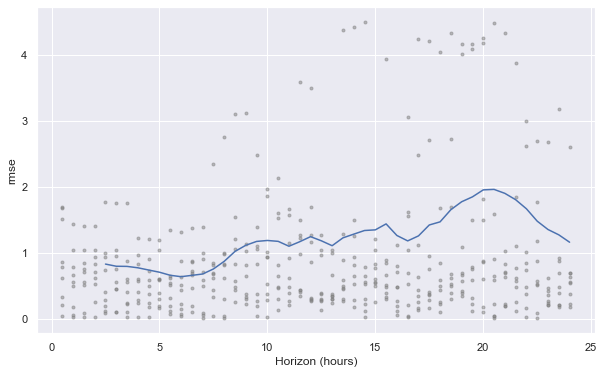

In [732]:
# Python
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [501]:
#正規化
#from sklearn.preprocessing import MinMaxScaler
#mmsc = MinMaxScaler()
# 訓練用のデータを正規化する
#x_train_norm = mmsc.fit_transform(x_train)
# 訓練用データを基準にテストデータも正規化
#x_test_norm = mmsc.transform(x_test)

#print(x_train_norm.max()) #1.0
#print(x_train_norm.min()) #0.0
# test用はtrainを基準に標準化してるので、多少0,1からずれる
#print(x_test_norm.max()) #1.0357142857142858
#print(x_test_norm.min()) #-0.017857142857142877

1.0
0.0
1.0303030303030303
0.0


In [ ]:
# modeling with 3 type
#from sklearn import svm
#modelSVM_ST = svm.LinearSVC(penalty='l2', loss='hinge', dual=True, tol=1e-3).fit(x_train_norm, y_train)
#modelSVM_L2 = svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=1e-3).fit(x_train, y_train)
#modelSVM_L1 = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=1e-3).fit(x_train, y_train)

In [ ]:
#from sklearn.linear_model import LogisticRegression
#modelCLF = LogisticRegression(penalty='l2', solver='sag', random_state=0).fit(x_train, y_train)

In [ ]:
# eveluate the model with train & validation data set
#ここでは trainとvalidでモデル評価する (単純なモデル評価)

#print("SVM_ST_Train set score: {:.2f}". format(model.score(x_train, y_train)))
#print("SVM_ST_Test set score: {:.2f}". format(model.score(x_test, y_test)))

#print("SVM_L2_Train set score: {:.2f}". format(model.score(x_train, y_train)))
#print("SVM_L2_Test set score: {:.2f}". format(model.score(x_test, y_test)))

#print("SVM_L1_Train set score: {:.2f}". format(model.score(x_train, y_train)))
#print("SVM_L1_Test set score: {:.2f}". format(model.score(x_test, y_test)))

#print("CLF_L1_Train set score: {:.2f}". format(modelCLF.score(x_train, y_train)))
#print("CLF_L1_Test set score: {:.2f}". format(modelCLF.score(x_test, y_test)))

In [ ]:
#y_preds_modelSVM_ST = pd.DataFrame(modelSVM_ST.predict(x_test)).round()
#y_preds_modelSVM_L2 = pd.DataFrame(modelSVM_L2.predict(x_test)).round()
#y_preds_modelSVM_L1 = pd.DataFrame(modelSVM_L1.predict(x_test)).round()
#y_preds_model_CLF = pd.DataFrame(modelCLF.predict(x_test)).round()

In [ ]:
#from sklearn.metrics import mean_squared_error
#from numpy import sqrt
#rmse = sqrt(mean_squared_error(y_train, y_preds_model_RF))
#print('Val RMSE: %.3f' % rmse)

# Validation

- Validation

Type of train/test split is identified and used for validation
Type of public/private split is identified

[cross validation]

In [134]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [135]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelRF, x_train, y_train)
print("Cross-validation score: {}".format(scores))

Cross-validation score: [0.72327321 0.72321126 0.73138019]


In [136]:
print("Avarage cross-validation score: {:.2f}".format(scores.mean()))

Avarage cross-validation score: 0.73


In [137]:
#分割数を指定するには cｖで指定する
scores = cross_val_score(modelRF, x_train, y_train, cv=10)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.69485812 0.73060434 0.74611967 0.6776483  0.78210243 0.71693081
 0.78267026 0.76285111 0.6710756  0.75417858]


In [138]:
print("Avarage cross-validation score: {:.2f}".format(scores.mean()))

Avarage cross-validation score: 0.73


[K hold]

In [139]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)
print("Cross-validation scores:\n{}".format(cross_val_score(modelRF, x_train, y_train, cv=kfold)))

Cross-validation scores:
[0.69277091 0.73363001 0.74469275 0.67503511 0.78185726 0.71863532
 0.78419103 0.7609482  0.67238062 0.75520385]


[LeaveOneOut] (時間かかりすぎ、スキップ)

In [ ]:
# １つ抜き交差検証
#from sklearn.model_selection import LeaveOneOut
#loo = LeaveOneOut()
#scores = cross_val_score(modelRF, x_train, y_train, cv=loo)
#print("Number of cv iterations: ", len(scores))
#print("Mean accuracy: {:.2f}".format(scores.mean()))

[Shuffle]

In [ ]:
# データセットの50%を訓練セット、50%をテストセットにして１０回分割を繰り返す例
#from sklearn.model_selection import ShuffleSplit
#%precision 3
#shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
#scores = cross_val_score(modelRF, x_train, y_train, cv=shuffle_split)
#print("Cross-validation scores\n{}".format(scores))

# グリッドリサーチ

In [140]:
#RandomForestのパラメーターチューニング
from sklearn.model_selection import RandomizedSearchCV
from random import randint
modelRF = RandomForestRegressor(
    n_estimators=200,
  max_depth=3,
  bootstrap=True,
  criterion='mse'
).fit(x_train, y_train)

In [141]:
# predict target
#y_preds_model_Line = pd.DataFrame(modelLine.predict(x_test)).round()
y_preds_model_RF = pd.DataFrame(modelRF.predict(x_train)).round()
#y_preds_model_XGB = pd.DataFrame(modelXGB.predict(x_train)).round()

In [142]:
y_preds_model_RF_valid = pd.DataFrame(modelRF.predict(x_valid)).round()

In [143]:
# Measure the score of RMSE which is the mesure to evaluate on this competition 
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_train, y_preds_model_RF))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 2.504


In [144]:
rmse = sqrt(mean_squared_error(y_valid, y_preds_model_RF_valid))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 2.440


Test XGBoost <p>
And, optimise the hyper parameter based on "RMSE"

In [145]:
#XGBoostのパラメーターチューニング
modelXGB = XGBRegressor(
    colsample_bytree=0.4,
    gamma=0.1,
    max_depth=13,
    min_child_weight=3,
    learning_rate=0.01,
    subsample=1.0,
    n_estimators=200,
    scale_pos_weight=1,
)
modelXGB.fit(
    x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_valid, y_valid)]
)

[0]	validation_0-rmse:9.10465	validation_1-rmse:9.00194
[1]	validation_0-rmse:9.02056	validation_1-rmse:8.92036
[2]	validation_0-rmse:8.93688	validation_1-rmse:8.83777
[3]	validation_0-rmse:8.85406	validation_1-rmse:8.75633
[4]	validation_0-rmse:8.77179	validation_1-rmse:8.67547
[5]	validation_0-rmse:8.69100	validation_1-rmse:8.59707
[6]	validation_0-rmse:8.61039	validation_1-rmse:8.51753
[7]	validation_0-rmse:8.53133	validation_1-rmse:8.44041
[8]	validation_0-rmse:8.45222	validation_1-rmse:8.36227
[9]	validation_0-rmse:8.37402	validation_1-rmse:8.28509
[10]	validation_0-rmse:8.29709	validation_1-rmse:8.20936
[11]	validation_0-rmse:8.22128	validation_1-rmse:8.13453
[12]	validation_0-rmse:8.14559	validation_1-rmse:8.05968
[13]	validation_0-rmse:8.07118	validation_1-rmse:7.98689
[14]	validation_0-rmse:7.99753	validation_1-rmse:7.91504
[15]	validation_0-rmse:7.92420	validation_1-rmse:7.84218
[16]	validation_0-rmse:7.85152	validation_1-rmse:7.77079
[17]	validation_0-rmse:7.77987	validation

[144]	validation_0-rmse:2.80007	validation_1-rmse:3.05136
[145]	validation_0-rmse:2.78149	validation_1-rmse:3.03688
[146]	validation_0-rmse:2.76290	validation_1-rmse:3.02238
[147]	validation_0-rmse:2.74436	validation_1-rmse:3.00802
[148]	validation_0-rmse:2.72660	validation_1-rmse:2.99450
[149]	validation_0-rmse:2.70934	validation_1-rmse:2.98098
[150]	validation_0-rmse:2.69182	validation_1-rmse:2.96760
[151]	validation_0-rmse:2.67417	validation_1-rmse:2.95392
[152]	validation_0-rmse:2.65665	validation_1-rmse:2.94040
[153]	validation_0-rmse:2.64002	validation_1-rmse:2.92746
[154]	validation_0-rmse:2.62379	validation_1-rmse:2.91451
[155]	validation_0-rmse:2.60772	validation_1-rmse:2.90184
[156]	validation_0-rmse:2.59124	validation_1-rmse:2.88876
[157]	validation_0-rmse:2.57494	validation_1-rmse:2.87608
[158]	validation_0-rmse:2.55944	validation_1-rmse:2.86388
[159]	validation_0-rmse:2.54388	validation_1-rmse:2.85198
[160]	validation_0-rmse:2.52904	validation_1-rmse:2.84098
[161]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=13,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [146]:
print("XGB_Train set score: {:.2f}". format(modelXGB.score(x_train, y_train)))
print("XGB_Valid set score: {:.2f}". format(modelXGB.score(x_valid, y_valid)))

XGB_Train set score: 0.78
XGB_Valid set score: 0.65


In [147]:
y_preds_model_XGB = pd.DataFrame(modelXGB.predict(x_train)).round()

In [148]:
# Measure the score of RMSE which is the mesure to evaluate on this competition 
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_train, y_preds_model_XGB))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 2.067


In [149]:
y_preds_model_XGB_valid = pd.DataFrame(modelXGB.predict(x_valid)).round()

In [150]:
# Measure the score of RMSE which is the mesure to evaluate on this competition 
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_valid, y_preds_model_XGB_valid))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 2.520


# Visualisation of the model performance 

<やりたいこと>
複数モデルを線形チャートで比較表示させたい。できれば

※
[Explanable easily but conservative]
Linear model
ARIMA, ARIMAX, etc
Prophet



# Making combined price data with all the tradable price

必要なのは、Spot price, 予測後のClose　price

# Calculate trading performance (VaR, Sharp-ratio)

## VaR

## Sharp-ratio